# Credit to Shreya Kapoor, https://github.com/ShreyaKapoor18/BCI_Neurotech

In [1]:

#%%
import mne
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
#from mne_bids import BIDSPath, read_raw_bids/
from scipy.io import loadmat
import mne
from mne.viz import plot_alignment, snapshot_brain_montage
from mne.time_frequency import fit_iir_model_raw
import gc
from scipy import signal
gc.enable()

col_names = [f'CH_{i}' for i in range(1, 61)]
col_names.extend(['paradigm_info'])
print(len(col_names))
sampling_freq = 1200
ch_types =['misc'] + ['ecog'] * 60 + ['stim']

info = mne.create_info(ch_names=["time"] + col_names, ch_types=ch_types, sfreq=sampling_freq)
# Load the data
data = loadmat("ECoG_Handpose.mat")['y']
# Index 1-60 means channels 2-61
raw = mne.io.RawArray(data[0:62,:], info) # we dont need the first channel
gc.collect()

raw.load_data().resample(sampling_freq )  #nyquist theorem
events = mne.find_events(raw, stim_channel="paradigm_info")
print(events)
raw.pick_types(ecog=True)
#%%
event_id = dict( fist_movement = 1 , peace_movement = 2 , open_hand = 3 )



61
Creating RawArray with float64 data, n_channels=62, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
[[ 14496      0      3]
 [ 20256      0      1]
 [ 26112      0      3]
 [ 31680      0      2]
 [ 37440      0      2]
 [ 43056      0      3]
 [ 48000      0      3]
 [ 53760      0      2]
 [ 58896      0      3]
 [ 64320      0      1]
 [ 69792      0      2]
 [ 75264      0      2]
 [ 81120      0      2]
 [ 86256      0      3]
 [ 91200      0      2]
 [ 97056      0      2]
 [102768      0      1]
 [108192      0      2]
 [113568      0      3]
 [118608      0      1]
 [123888      0      2]
 [128928      0      3]
 [134640      0      3]
 [139632      0      3]
 [144768      0      1]
 [150336      0      2]
 [155568      0      1]
 [161232      0      1]
 [167040      0      2]
 [172368      0      3]
 [177408      0      2]
 [183216      0  

In [2]:
timings = data[0,:]
delta_t = timings[1] - timings[0]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1e+02 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 100.00 Hz (-6 dB cutoff frequency: 550.00 Hz)
- Filter length: 159 samples (0.133 sec)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.50
- Lower 

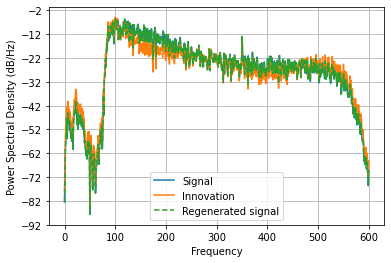

In [3]:

#%%
'''
After excluding channels that were notably bad due to
high impedance, we re-referenced the data by the common
average. After that, a notch-filter cascade (recursive 6th-order
Butterworth, bandwidth: 5 Hz) up to the 6th harmonic was
used to remove interference peaks from the spectrum at integer
multiples of the power line frequency'''

# They set the trial length to 0.75 seconds pre- and post-onset, respectively
# full_mean = raw._data.mean(axis=0)
#mean_col =# get the meaning of the column
# raw._data -= full_mean # this could cause bias though
raw.filter(100, 500)
# raw.filter(1, None)
raw.set_eeg_reference("average")
nf = 50
raw.notch_filter([nf], notch_widths=2, trans_bandwidth=1)  # raw.notch_filter([60], trans_bandwidth=5)


#picks = mne.pick_types(raw.info, meg='grad', exclude='bads')

order = 5  # define model order
#picks = picks[:1]

# from https://mne.tools/stable/auto_examples//time_frequency/temporal_whitening.html#sphx-glr-auto-examples-time-frequency-temporal-whitening-py
# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw, order=order, picks=["ecog"], tmin=timings[0], tmax=timings[-1])
d, times = raw[0, 10000:20000]  # look at one channel from now on
d = d.ravel()  # make flat vector
innovation = signal.convolve(d, a, "valid")
d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length

# plt.close('all')
# plt.figure()
# plt.plot(d[:100], label='signal')
# plt.plot(d_[:100], label='regenerated signal')
# plt.legend()

plt.figure()
plt.psd(d, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(innovation, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(d_, Fs=raw.info['sfreq'], NFFT=2048, linestyle='--')
plt.legend(('Signal', 'Innovation', 'Regenerated signal'))
plt.show()
#%%
#raw.plot()
#plt.savefig('results/mne_plot.png')
#picks=['CH_5', 'CH_10', 'CH_15']

#raw.plot_psd(average=True)
#plt.savefig('results/plot_spectral_density.png')

#plt.savefig('results/ecog.png')
#raw.plot_sensors(ch_type='ecog')

# Then we remove line frequency interference



In [4]:
# raw.filter?

In [5]:
m = raw._data
m.mean(), m.std(), m.shape

(4.9169579503366714e-18, 75.95195725309549, (60, 507025))

Effective window size : 1.707 (s)


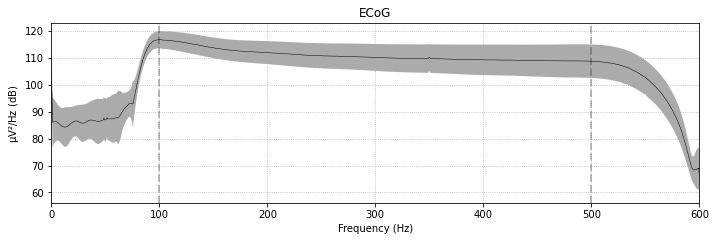

0

In [6]:
raw.plot_psd(average=True)
0

In [7]:
# raw._data /= raw._data.max()

In [8]:
epochs = mne.Epochs(raw, events, tmin=0., tmax=1.5, baseline=(0, 0))
print(epochs)

Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  90 events (good & bad), 0 - 1.5 sec, baseline 0 – 0 sec, ~60 kB, data not loaded,
 '1': 30
 '2': 30
 '3': 30>


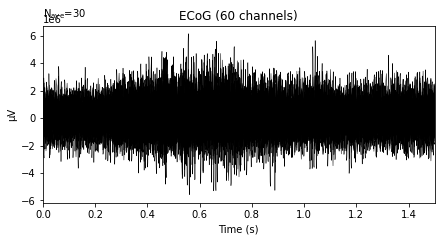

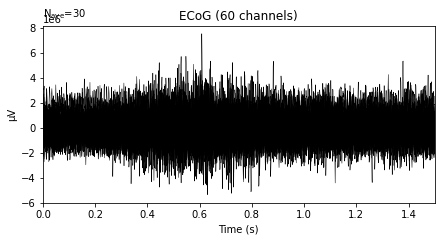

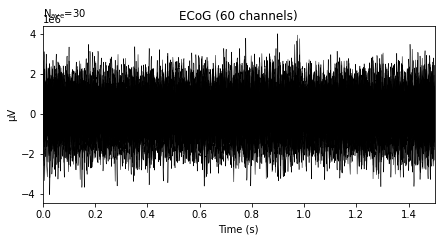

In [9]:
for i in '123':
    epochs[i].average().plot()

In [10]:
import mne.decoding


# for n_components in range(1, 30):
# lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
# clf = sklearn.pipeline.Pipeline([('CSP', csp), ('LDA', lda)])
# scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
# print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
#                                                           class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit(epochs.get_data(), epochs.events[:, -1])

# csp.plot_patterns(epochs.info, ch_type='ecog', units='Patterns (AU)', size=1.5)
# plt.show()

Loading data for 90 events and 1801 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 32 (2.2e-16 eps * 60 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 32 (2.2e-16 eps * 60 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 60 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small M

CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=True, n_components=4, norm_trace=False, rank=None, reg=None,
  transform_into='average_power')

In [11]:
# To be used
csp_cache = {}
model_cache = {}

In [12]:
group_cache = {"csp": csp_cache}

In [13]:
predictor_cache = {}

In [14]:
from tqdm.auto import tqdm, trange
import random


random.seed(16)
data = epochs.get_data()
n_splits = 16
n_folds = 3
fold_size = len(data) // n_folds
folds = []
for s in trange(n_splits):
    fold = []
    ts = list(range(len(data)))
    random.shuffle(ts)
    for i in range(0, len(data), fold_size):
        x = data[ts][i:i+fold_size]
        y = epochs.events[ts][i:i+fold_size, -1]
        fold.append((x, y))
    folds.append(fold)

Loading data for 90 events and 1801 original time points ...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 26.4583±2.6707
percentage_accuracy_score: 26.4583


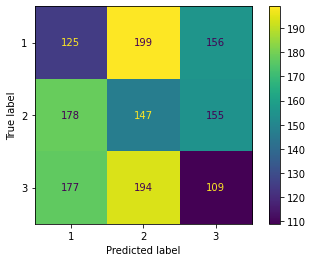





Pipeline(steps=[('xdawn', XdawnCovariances(estimator='oas')), ('mdm', MDM())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 70.7407±5.8079
percentage_accuracy_score: 70.6944


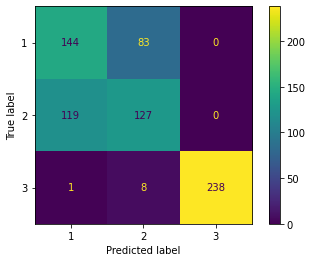





Pipeline(steps=[('xdawn', XdawnCovariances(estimator='oas', nfilter=2)),
                ('mdm', MDM())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 68.7037±5.3812
percentage_accuracy_score: 68.3333


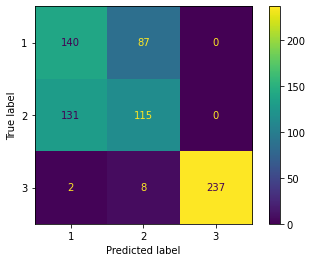





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 63.4375±5.5875
percentage_accuracy_score: 63.4375


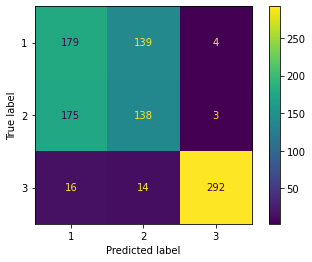





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 36.5278±12.5930
percentage_accuracy_score: 38.2292


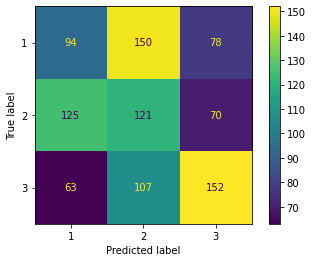





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 67.0139±8.8123
percentage_accuracy_score: 66.8750


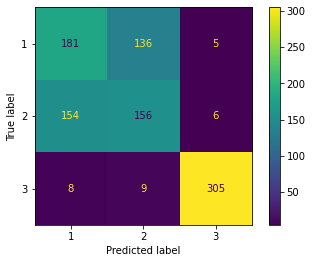





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 63.0556±7.7951
percentage_accuracy_score: 63.3333


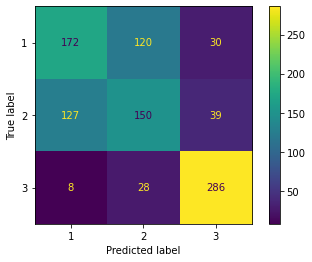





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 44.0625±10.4467
percentage_accuracy_score: 44.1667


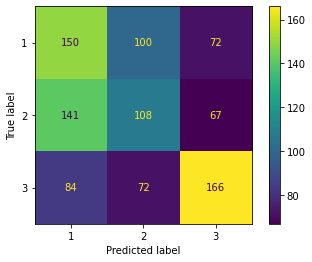





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 31.3194±11.6118
percentage_accuracy_score: 32.9167


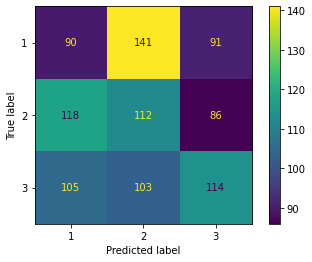





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.5486±9.8977
percentage_accuracy_score: 63.9583


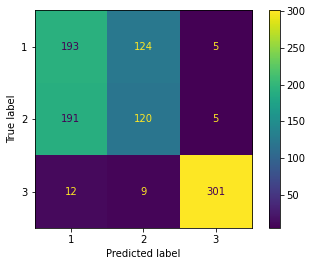





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 59.2708±12.5826
percentage_accuracy_score: 60.7292


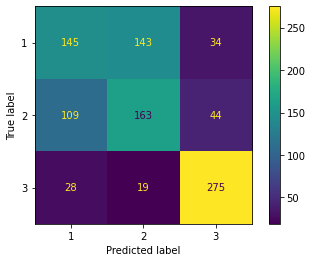





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedPredictor(model=CachedTrainer(group='topo',
                                                                                     invariant=True,
                                                                                     kwargs={},
                                                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                                                ('1',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                  

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 92.2917±2.2037
percentage_accuracy_score: 92.2917


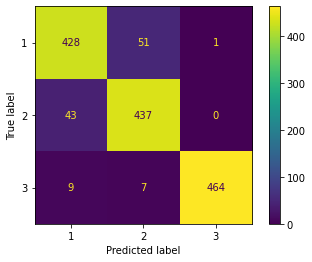





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedPredictor(model=CachedTrainer(group='topo',
                                                                                     invariant=True,
                                                                                     kwargs={},
                                                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                                                ('1',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                  

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 84.7222±4.3656
percentage_accuracy_score: 84.7222


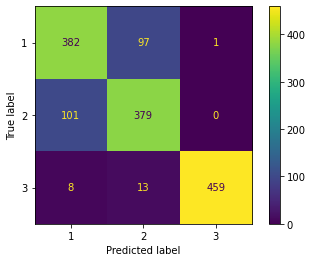





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedPredictor(model=CachedTrainer(group='topo',
                                                                                     invariant=True,
                                                                                     kwargs={},
                                                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                                                ('1',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                  

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 91.2500±3.3304
percentage_accuracy_score: 91.2500


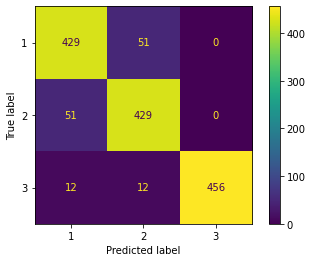





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedPredictor(model=CachedTrainer(group='topo',
                                                                                     invariant=True,
                                                                                     kwargs={},
                                                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                                                ('1',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                  

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 57.1528±6.8939
percentage_accuracy_score: 57.1528


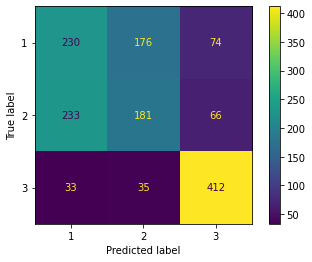





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 61.3889±4.1107
percentage_accuracy_score: 61.3889


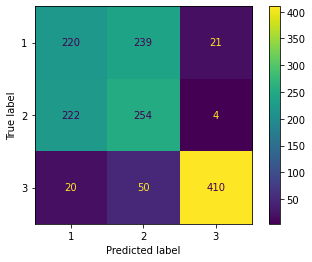





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 62.3611±3.4667
percentage_accuracy_score: 62.3611


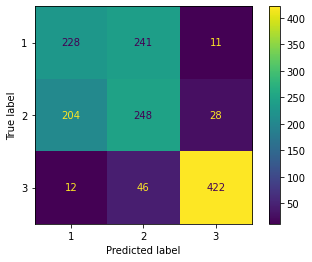





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 61.5972±4.0248
percentage_accuracy_score: 61.5972


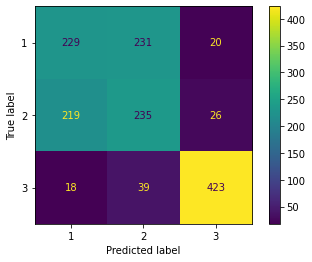





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fa74568cf70>))),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.1111±7.9349
percentage_accuracy_score: 51.1111


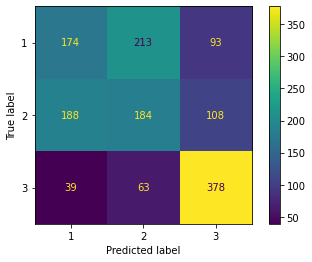





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 94.3750±2.0211
percentage_accuracy_score: 94.3750


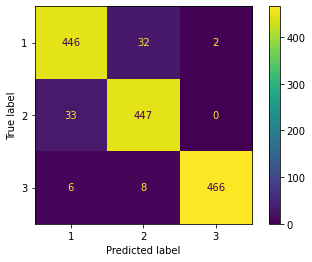





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 93.6111±3.3907
percentage_accuracy_score: 93.6111


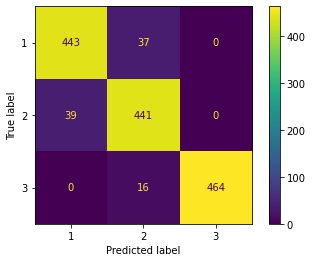





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 92.5694±2.2811
percentage_accuracy_score: 92.5694


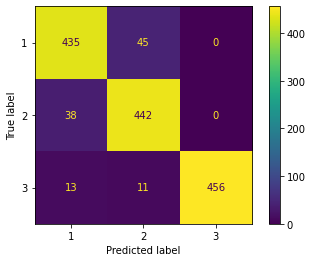





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 75.1389±9.2034
percentage_accuracy_score: 75.1389


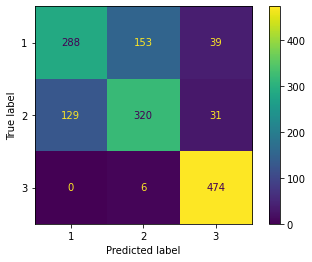





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 55.4167±5.7316
percentage_accuracy_score: 55.4610


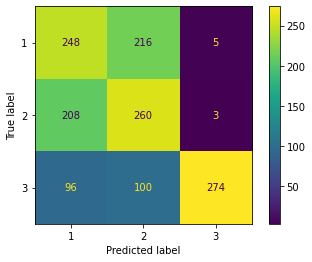





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 50.0000±5.3142
percentage_accuracy_score: 50.1418


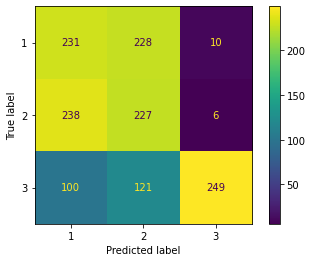





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 52.0139±4.7340
percentage_accuracy_score: 52.1986


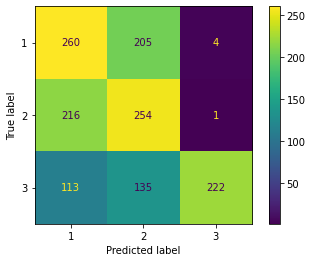





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.9792±4.4400
percentage_accuracy_score: 52.1986


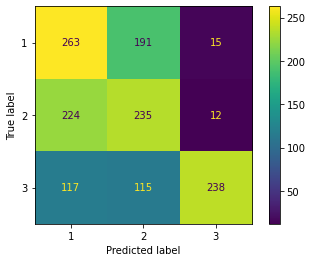





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 58.1944±6.0461
percentage_accuracy_score: 58.2270


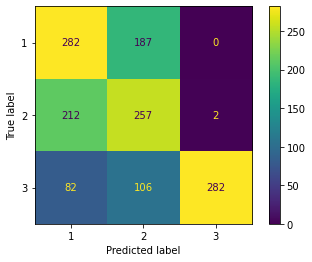





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.9931±5.2676
percentage_accuracy_score: 54.0426


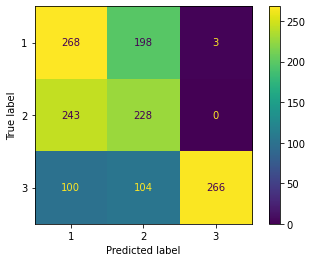





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.0208±5.6518
percentage_accuracy_score: 52.9078


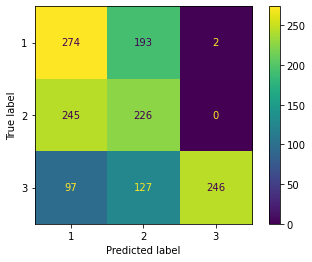





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.6111±5.0690
percentage_accuracy_score: 53.4043


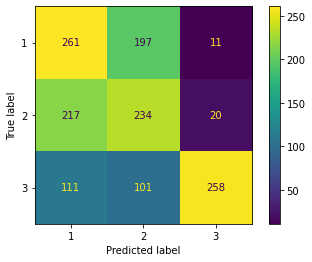





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.7153±3.7819
percentage_accuracy_score: 53.7589


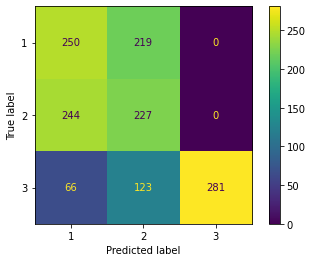





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 52.3264±3.9393
percentage_accuracy_score: 52.4113


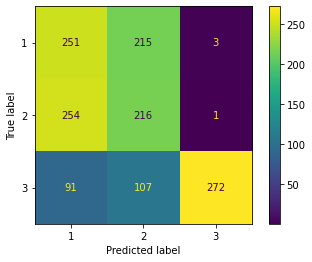





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.4375±4.5906
percentage_accuracy_score: 53.4752


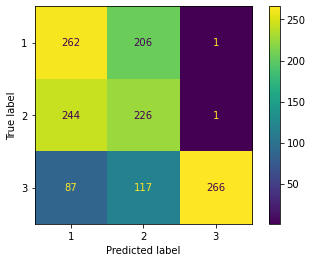





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 52.7778±3.9869
percentage_accuracy_score: 52.7660


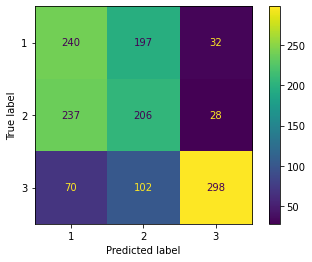





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.4236±3.1912
percentage_accuracy_score: 51.4894


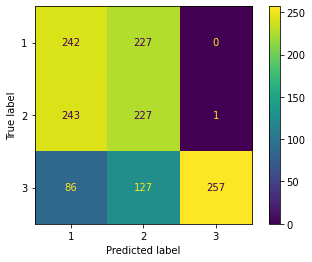





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 50.6597±4.7759
percentage_accuracy_score: 50.7092


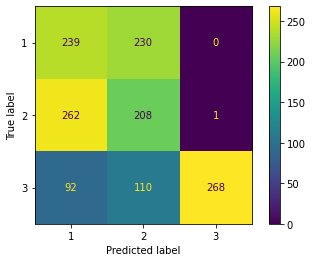





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 50.8333±3.6536
percentage_accuracy_score: 50.8511


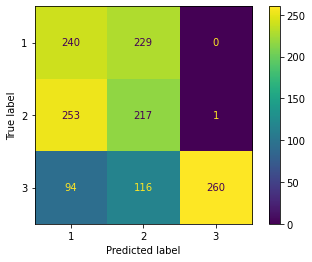





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.1597±5.7859
percentage_accuracy_score: 53.1206


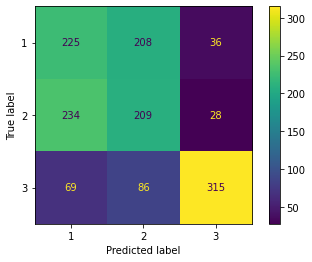





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.8403±4.7006
percentage_accuracy_score: 51.9149


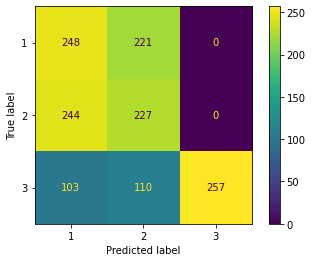





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 50.0347±5.3159
percentage_accuracy_score: 50.0709


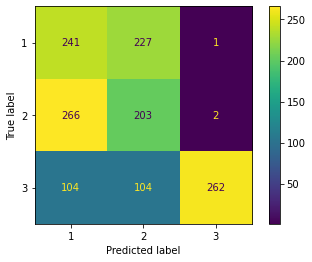





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.0764±4.5579
percentage_accuracy_score: 51.0638


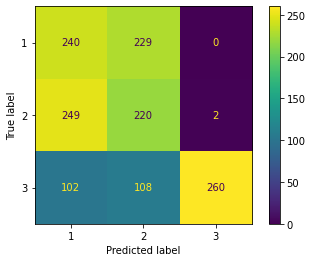





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 52.9514±5.8026
percentage_accuracy_score: 52.9787


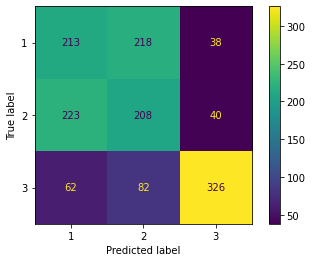





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.0764±4.0752
percentage_accuracy_score: 51.2057


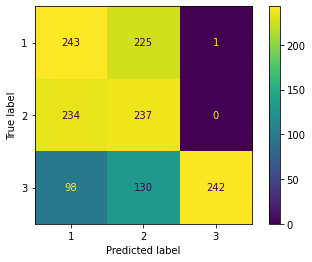





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 49.2708±5.4600
percentage_accuracy_score: 49.2908


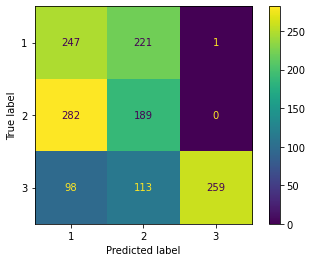





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 49.2361±3.7622
percentage_accuracy_score: 49.2908


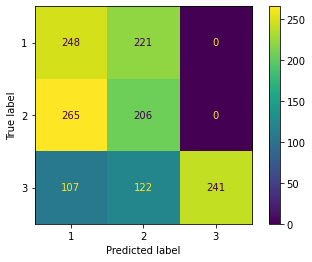





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 53.6458±5.1143
percentage_accuracy_score: 53.6879


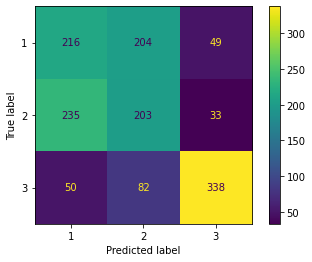





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.0417±4.4871
percentage_accuracy_score: 51.0638


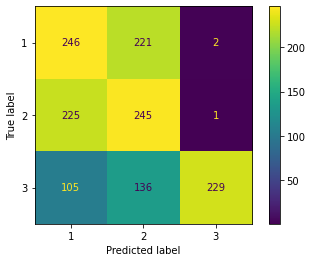





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 47.1528±5.1515
percentage_accuracy_score: 47.2340


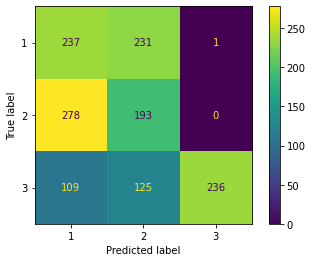





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 47.9514±4.2114
percentage_accuracy_score: 47.9433


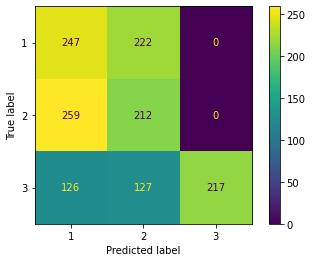





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 55.0347±4.3456
percentage_accuracy_score: 55.1064


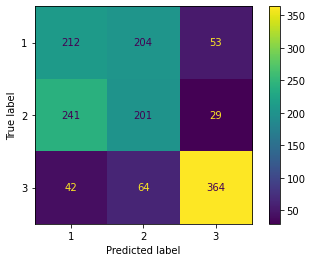





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 53.7153±3.7819
percentage_accuracy_score: 53.7589


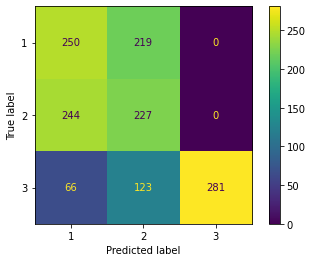





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.3264±3.9393
percentage_accuracy_score: 52.4113


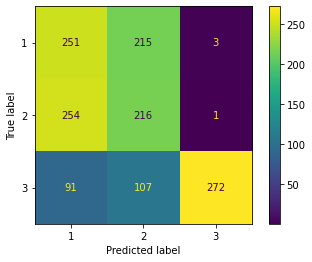





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 53.4375±4.5906
percentage_accuracy_score: 53.4752


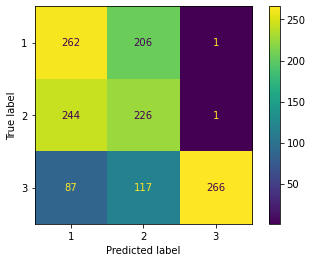





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.7778±3.9869
percentage_accuracy_score: 52.7660


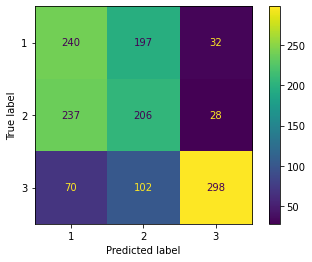





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 37.0833±4.4074
percentage_accuracy_score: 37.0833


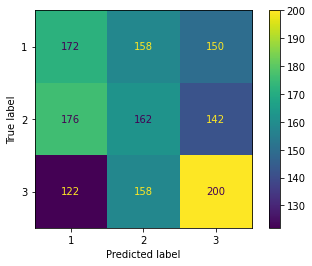





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 36.3194±4.0772
percentage_accuracy_score: 36.3194


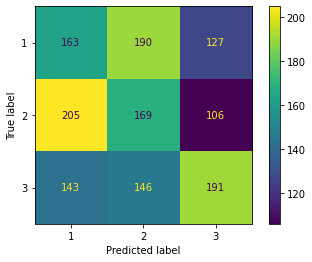





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 37.2222±5.3720
percentage_accuracy_score: 37.2222


/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


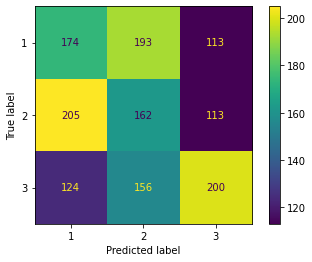





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 37.8472±4.3117
percentage_accuracy_score: 37.8472


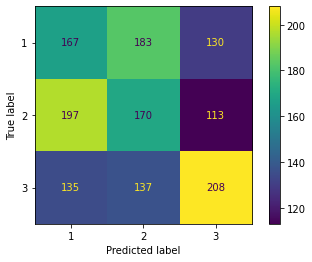





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 41.8056±3.9650
percentage_accuracy_score: 41.7730


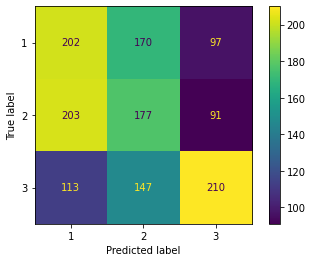





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 39.5139±5.4429
percentage_accuracy_score: 39.3617


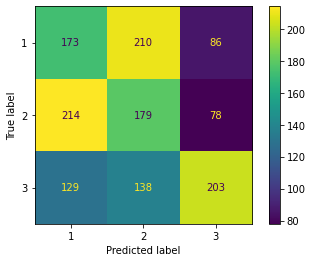





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 39.0972±5.0341
percentage_accuracy_score: 39.0780


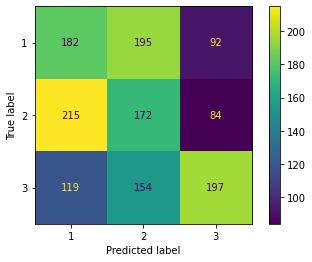





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 42.9861±4.3518
percentage_accuracy_score: 42.8369


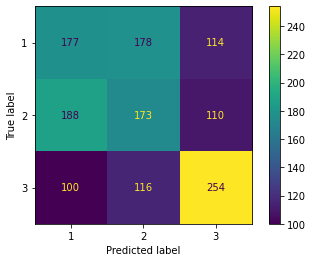





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 42.6736±4.6282
percentage_accuracy_score: 42.6241


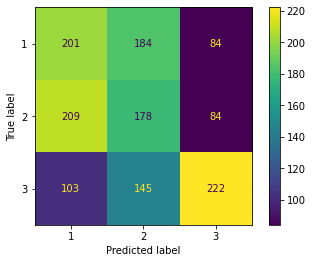





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 40.3472±4.6434
percentage_accuracy_score: 40.2128


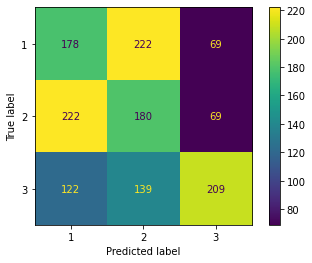





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

accuracy: 40.2083±5.6001
percentage_accuracy_score: 40.1418


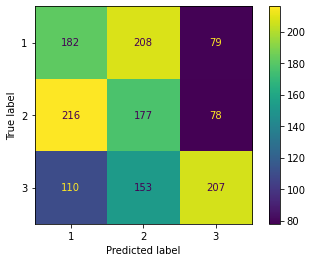





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 42.9167±4.3546
percentage_accuracy_score: 42.9078


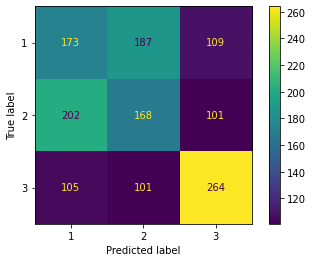





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 44.2014±2.9980
percentage_accuracy_score: 44.1135


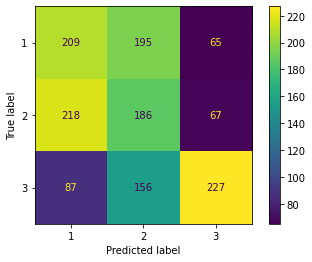





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 40.5903±4.8491
percentage_accuracy_score: 40.4255


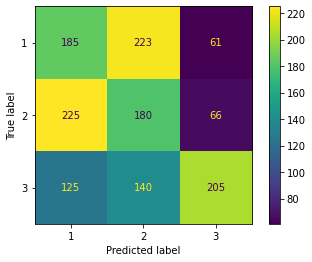





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

accuracy: 40.0694±5.6173
percentage_accuracy_score: 39.9291


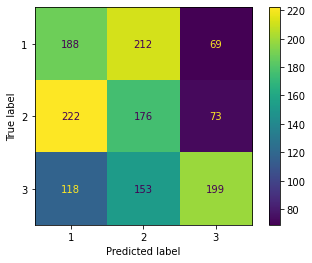





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 43.5764±3.6376
percentage_accuracy_score: 43.4043


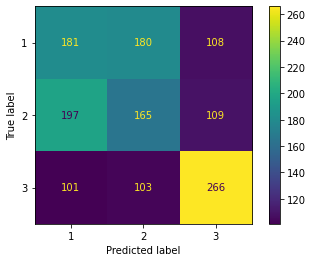





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 16},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 43.4722±4.0612
percentage_accuracy_score: 43.4752


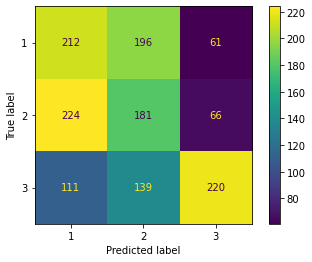





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 16},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 42.0833±5.1201
percentage_accuracy_score: 41.9149


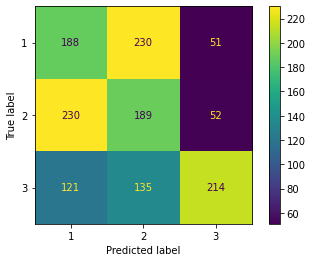





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 16},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 41.1806±5.3355
percentage_accuracy_score: 41.0638


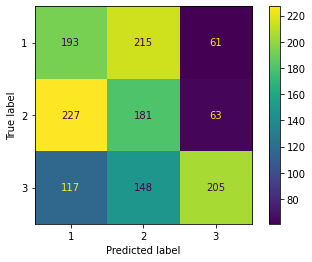





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 16},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691d30>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 44.0278±5.4839
percentage_accuracy_score: 43.9716


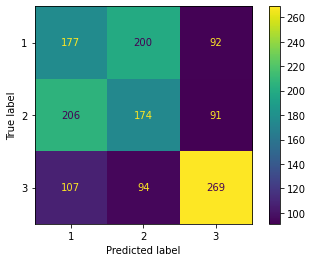





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 20},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 44.2708±3.8974
percentage_accuracy_score: 44.2553


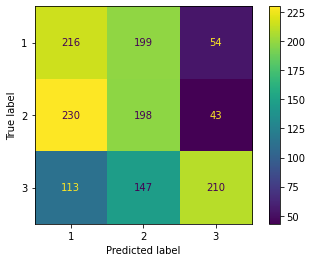





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 20},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 41.9097±5.0688
percentage_accuracy_score: 41.7730


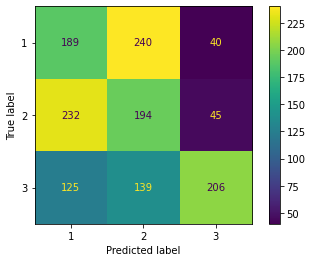





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 20},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 41.9792±5.7163
percentage_accuracy_score: 41.9149


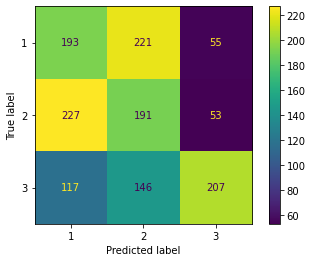





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 20},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691dc0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 45.9722±3.2364
percentage_accuracy_score: 45.8865


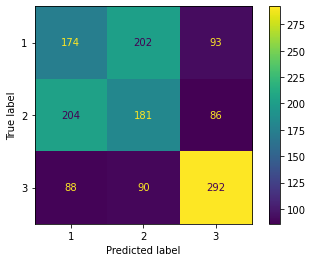





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 24},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 44.9306±4.8745
percentage_accuracy_score: 44.8936


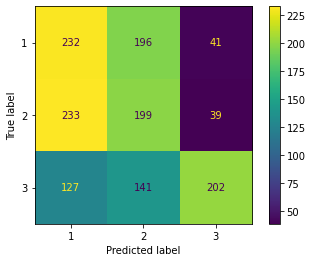





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 24},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 42.8472±5.4852
percentage_accuracy_score: 42.6241


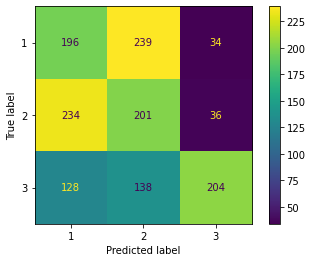





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 24},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 42.2222±5.8399
percentage_accuracy_score: 42.1277


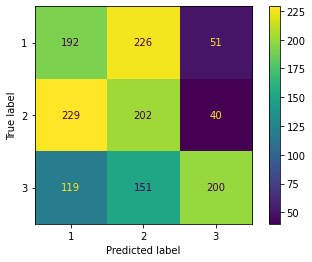





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 24},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691e50>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 44.6875±5.2520
percentage_accuracy_score: 44.7518


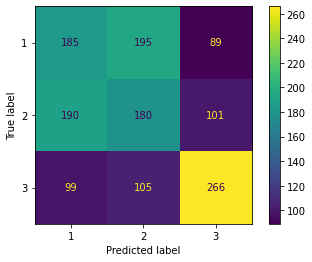





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 28},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 44.4792±4.5579
percentage_accuracy_score: 44.3972


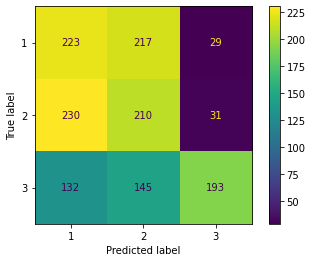





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 28},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 43.0208±4.6397
percentage_accuracy_score: 42.8369


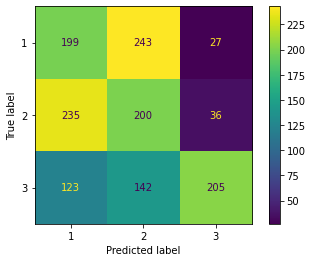





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 28},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 42.2222±5.7333
percentage_accuracy_score: 42.1277


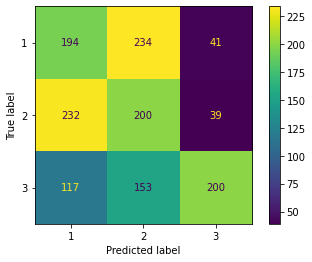





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 28},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ee0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 46.2153±3.5422
percentage_accuracy_score: 46.0993


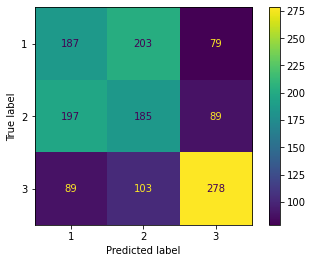





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 44.2014±2.9980
percentage_accuracy_score: 44.1135


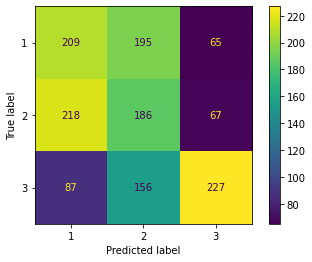





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 40.5903±4.8491
percentage_accuracy_score: 40.4255


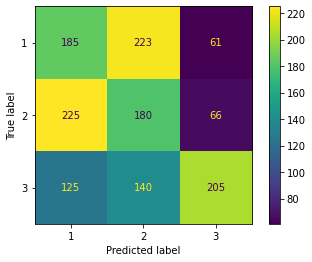





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 40.0694±5.6173
percentage_accuracy_score: 39.9291


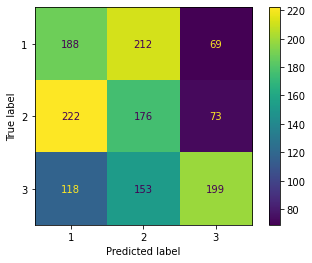





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 12},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691ca0>)),
                                                ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 43.5764±3.6376
percentage_accuracy_score: 43.4043


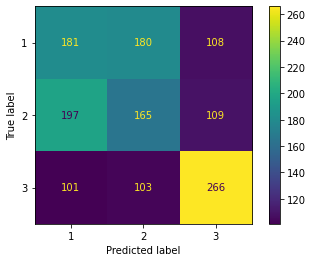





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=300, low=40))),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 66.3889±5.0384
percentage_accuracy_score: 66.3889


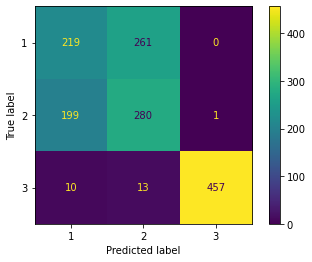





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=300, low=40))),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 35.9028±10.9129
percentage_accuracy_score: 35.9028


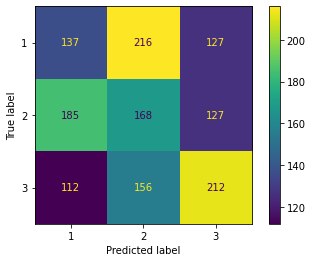





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=300, low=40))),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 82.8472±3.2148
percentage_accuracy_score: 82.8472


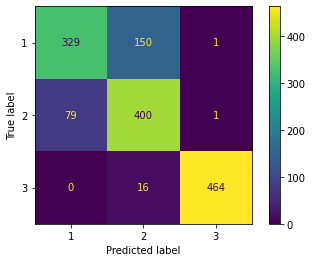





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=300, low=40))),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 72.7778±5.9187
percentage_accuracy_score: 72.7778


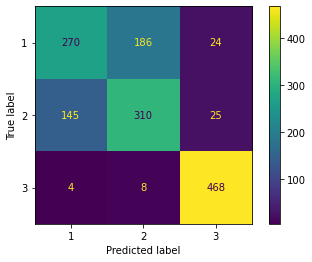





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=PSDWelch(high=300, low=40, n_fft=512))),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 67.2222±4.8908
percentage_accuracy_score: 67.2222


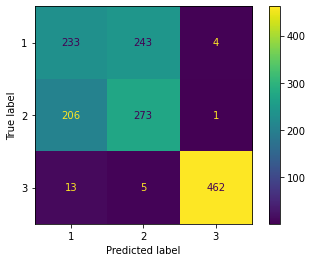





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=PSDWelch(high=300, low=40, n_fft=512))),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.3194±11.0639
percentage_accuracy_score: 51.3194


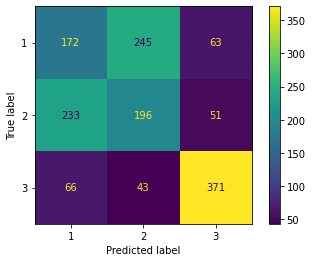





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=PSDWelch(high=300, low=40, n_fft=512))),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 81.6667±4.1759
percentage_accuracy_score: 81.6667


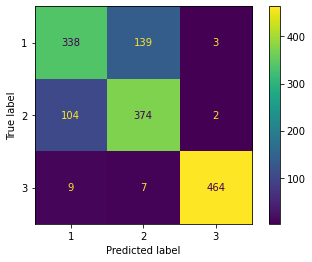





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=PSDWelch(high=300, low=40, n_fft=512))),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 79.1667±4.0919
percentage_accuracy_score: 79.1667


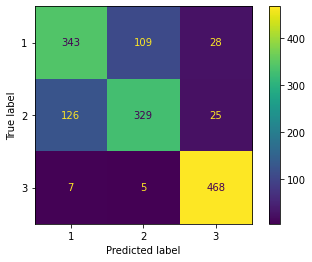





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=250, low=100))),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 70.1389±5.9040
percentage_accuracy_score: 70.1389


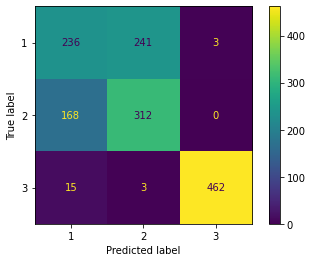





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=250, low=100))),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 33.2639±9.6343
percentage_accuracy_score: 33.2639


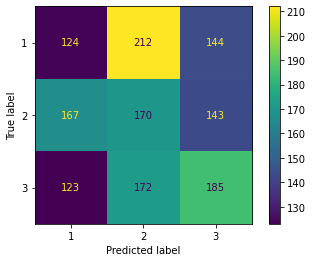





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=250, low=100))),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 83.6111±4.9923
percentage_accuracy_score: 83.6111


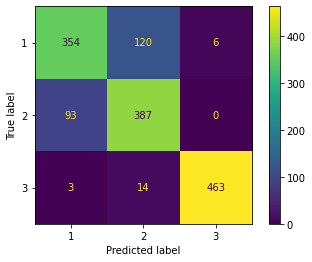





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', CachedPredictor(model=PSDWelch(high=250, low=100))),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 71.8750±4.7583
percentage_accuracy_score: 71.8750


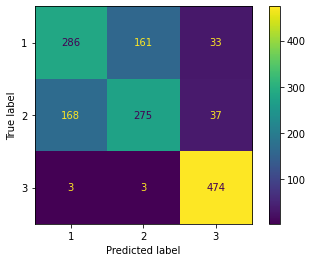





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                                                ('80hz',
                                                                                 CachedPredictor(model=BandPower(high=140,
                                                                                                                 low=80))),
                                                                                ('120hz',
                                                                                 CachedPredictor(model=BandPower(h

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 67.0139±5.6617
percentage_accuracy_score: 67.3050


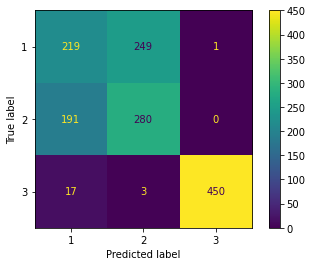





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                                                ('80hz',
                                                                                 CachedPredictor(model=BandPower(high=140,
                                                                                                                 low=80))),
                                                                                ('120hz',
                                                                                 CachedPredictor(model=BandPower(h

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 68.0903±5.2777
percentage_accuracy_score: 68.2270


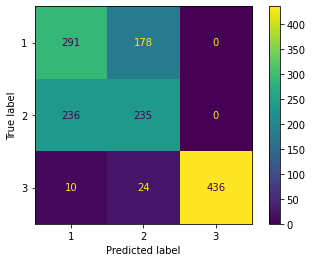





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                                                ('80hz',
                                                                                 CachedPredictor(model=BandPower(high=140,
                                                                                                                 low=80))),
                                                                                ('120hz',
                                                                                 CachedPredictor(model=BandPower(h

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 84.3403±4.8521
percentage_accuracy_score: 84.5390


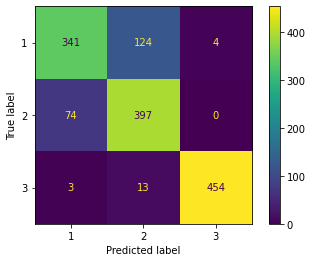





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 FeatureUnion(transformer_list=[('40hz',
                                                                                 CachedPredictor(model=BandPower(high=100,
                                                                                                                 low=40))),
                                                                                ('80hz',
                                                                                 CachedPredictor(model=BandPower(high=140,
                                                                                                                 low=80))),
                                                                                ('120hz',
                                                                                 CachedPredictor(model=BandPower(h

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 57.4306±5.1777
percentage_accuracy_score: 57.5887


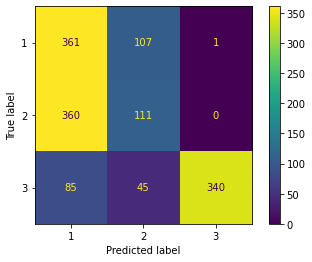





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('2',
                                                 CachedTrainer(group='csp',
                                                               kwarg...
                              

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.0417±4.4871
percentage_accuracy_score: 51.0638


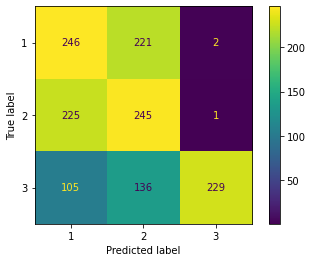





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('2',
                                                 CachedTrainer(group='csp',
                                                               kwarg...
                              

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 50.7986±4.4703
percentage_accuracy_score: 50.8511


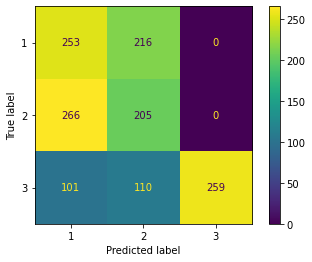





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('2',
                                                 CachedTrainer(group='csp',
                                                               kwarg...
                              

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 51.2153±5.0239
percentage_accuracy_score: 51.2057


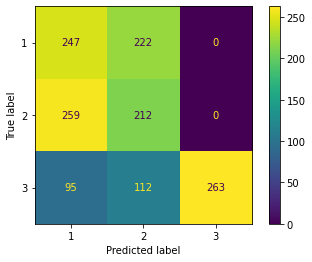





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('0',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 4},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691b80>)),
                                                ('1',
                                                 CachedTrainer(group='csp',
                                                               kwargs={'n_components': 8},
                                                               model_lambda=<function <listcomp>.<lambda> at 0x7fa745691c10>)),
                                                ('2',
                                                 CachedTrainer(group='csp',
                                                               kwarg...
                              

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/ax37/anaconda3/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


accuracy: 52.2222±5.9835
percentage_accuracy_score: 52.4113


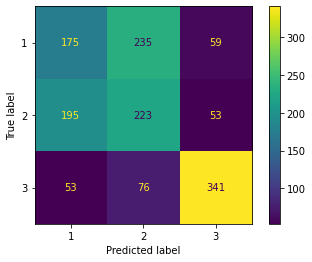

0

In [15]:
import sklearn.discriminant_analysis
import sklearn.linear_model
import sklearn.ensemble
import sklearn.pipeline
import sklearn.dummy
import scipy.signal
import pandas as pd
import contextlib
import io

import pyriemann # from catboost import CatboostClassifier

from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude, NumberOfPoints, PersistenceEntropy


def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def hash_xy(x, y):
    return hash((str(x), str(y)))

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x


def uni_concat(xs):
    if not xs:
        return
    if isinstance(xs[0], list):
        return sum(xs, [])
    else:
        try:
            return pd.concat(xs)
        except TypeError:
            return np.concatenate(xs)


def cross_fold(models, folds, metrics=[], multi_level=False):
    if not multi_level and len(folds[0]) == 2:  # Single-level (one cross-fold)
        folds = [folds]
    models = wrap_list(models)
    metrics = wrap_list(metrics) + [percentage_accuracy_score]
    scores = []
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        acc_samples = []
        avg_accs = []
        bar = tqdm(total=sum(map(len, folds)))
        for fold in folds:
            true_ = []
            test_accs_ = []
            for i, (x_test, y_test) in enumerate(fold):
                model_hash = hash((str(model), hash_xy(x_test, y_test)))
                if model_hash in model_cache:
                    y__test = model_cache[model_hash]
                else:
                    model_ = sklearn.base.clone(model)
                    x_train, y_train = map(uni_concat, zip(*(fold[:i] + fold[i+1:])))
                    try:
                        model_.fit(x_train, y_train)
                    except np.linalg.LinAlgError:
                        y__test = None
                    else:
                        y__test = model_.predict(x_test)
                    model_cache[model_hash] = y__test
                if y__test is None:
                    bar.update(1)
                    continue
                predicted.append(y__test)
                true_.append(y_test), true.append(y_test)
                test_acc = percentage_accuracy_score(y_test, y__test)
                test_accs_.append(test_acc), test_accs.append(test_acc)
                bar.update(1)
                bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                    f"sample accuracy: {sum(test_accs_) / len(test_accs_):.4f}, "
                                    f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
            try:
                acc_samples.append(sum(test_accs_) / len(test_accs_))
            except ZeroDivisionError:
                pass
        
        print(f"accuracy: {np.mean(acc_samples):.4f}±{np.std(acc_samples):.4f}")
        bar.close()
        true, predicted = uni_concat(true), uni_concat(predicted)
        for metric in metrics:
            # Accuracy decomposes cleanly, but other metrics might not
            score = metric(true, predicted)
            print(f"{metric.__name__}: {score:.4f}")
        # Final metric determines the result
        scores.append(score)  
        
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()


class CachedTrainer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model_lambda, group, kwargs=None, invariant=False):
        self.model_lambda = model_lambda
        self.group, self.kwargs = group, kwargs if kwargs is not None else {}
        self.invariant = invariant
    
    def fit(self, x, y):
        if not hasattr(self, "model"):
            # stateful
            h = hash_xy(x, y) if not self.invariant else 0
            if self.group not in group_cache:
                group_cache[self.group] = {}
            if h not in group_cache[self.group]:
                with contextlib.redirect_stdout(io.StringIO()):
                    c = self.model_lambda().fit(x, y)
                group_cache[self.group][h] = c
            self.model = sklearn.base.copy.copy(group_cache[self.group][h])
            for k, v in self.kwargs.items():
                setattr(self.model, k, v)  # hack for CSP models
        return self
    
    def transform(self, *args, **kwargs):
        assert hasattr(self, "model")
        return self.model.transform(*args, **kwargs)


class CachedPredictor(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model):
        self.model = model
        self.model_str = str(self.model)
    
    def fit(self, x, y):
        self.model.fit(x, y)
        return self
    
    def transform(self, x):
        predictor_hash = hash((self.model_str, str(x)))
        if predictor_hash not in predictor_cache:
            predictor_cache[predictor_hash] = self.model.transform(x)
        return predictor_cache[predictor_hash]

    
def butter_bandpass(lowcut, highcut, fs, order=5):
    return scipy.signal.butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y


class Combiner(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high):
        self.low, self.high = low, high
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        filtered = butter_bandpass_filter(x, self.low, self.high, sampling_freq)
        return np.log(np.mean(filtered ** 2, axis=-1))


class BandPower(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high):
        self.low, self.high = low, high
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        filtered = butter_bandpass_filter(x, self.low, self.high, sampling_freq)
        return np.log(np.mean(filtered ** 2, axis=-1))
    

class AllScaler(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def fit(self, x, y):
        self.std = x.std()
        return self
    
    def transform(self, x):
        return x / x.std()


def squeeze(x):
    return [np.squeeze(y).T for y in x]
    
    
    
class TopoFormer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_delay=1, dimension=1, stride=100, h_dim=(0,1),
                 metrics=["bottleneck", "wasserstein", "betti", "landscape", "silhouette", "heat"]):
        self.takens_kwargs = dict(time_delay=time_delay, dimension=dimension, stride=stride)
        self.stide = stride
        self.h_dim = h_dim
        self.metrics = metrics
        self.pipeline = CachedPredictor(sklearn.pipeline.Pipeline([
            ("takens", TakensEmbedding(**self.takens_kwargs)),
            ("squeeze", sklearn.preprocessing.FunctionTransformer(squeeze)),
            ("vr", VietorisRipsPersistence(homology_dimensions=h_dim)),
        ]))
        self.extractors = [Amplitude(metric=metric) for metric in metrics] + [
                           PersistenceEntropy(normalize=True, nan_fill_value=-1),
                           PersistenceEntropy(normalize=False, nan_fill_value=-1),
                           NumberOfPoints()
                          ]
        for k, v in self.takens_kwargs.items(): setattr(self, k, v)
        
    
    def fit(self, x, y=None):
        x_ = self.pipeline.fit_transform(x, y)
        for extractor in self.extractors:
            extractor.fit_transform(x_, y)
        return self
    
    def transform(self, x):
        x_ = self.pipeline.transform(x)
        features = [extractor.transform(x_)[:, :2] for extractor in self.extractors]
        return np.concatenate(features, axis=-1)



class PSDWelch(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high, n_fft=256):
        self.low, self.high, self.n_fft = low, high, n_fft
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        with contextlib.redirect_stdout(io.StringIO()):
            bp, freqs = mne.time_frequency.psd_array_welch(x, sampling_freq,
                                                      fmin=self.low, fmax=self.high,
                                                      n_fft=int(self.n_fft), average="mean")
        return bp.reshape((bp.shape[0], -1))

band_features = [sklearn.pipeline.FeatureUnion([("40hz", CachedPredictor(BandPower(40, 100))),
                                    ("80hz", CachedPredictor(BandPower(80, 140))),
                                    ("120hz", CachedPredictor(BandPower(120, 180))),
                                    ("160hz", CachedPredictor(BandPower(160, 220)))])]
csp_features = [CachedTrainer(
        lambda: mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False), "csp", dict(n_components=c))
                 for c in range(4, 16*2, 4)]
csp_features.append(csp_features[2])
welch_features = [
    CachedPredictor(PSDWelch(40, 300, 256)),
    CachedPredictor(PSDWelch(40, 300, 512)),
    CachedPredictor(PSDWelch(100, 250, 256))]


class ERPFeature(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, window):
        self.window=window
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        return (x
                [:, :, :x.shape[-1] // self.window * self.window]
                .reshape(x.shape[:-1] + (self.window, -1))
                .mean(axis=-1)
                .reshape((x.shape[0], -1)))

    
class Model3D(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model):
        self.model = model
    
    def fit(self, x, y=None):
        if x.ndim == 2:
            self.model.fit(x, y)
            return self
        # TODO make consistent with time series format
        x_ = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        self.model.fit(x_, y)
        return self
    
    def transform(self, x):
        if x.ndim == 2:
            return self.model.transform(x)
        x = x.swapaxes(-1, -2)
        p = self.model.transform(x.reshape((x.shape[0] * x.shape[1], x.shape[2]))).reshape((x.shape[0], x.shape[1], -1))
        x = x.swapaxes(-1, -2)
        return p
    
    
    def predict(self, x):
        if x.ndim == 2:
            return self.model.predict(x)
        p = self.model.predict(x.reshape((x.shape[0], x.shape[1] * x.shape[2])))
        return p

                                                
erp_features = [ERPFeature(20),  # 75ms
                # ERPFeature(80)
               ]

topological_features = [CachedPredictor(CachedTrainer(lambda: TopoFormer(), "topo", invariant=True))]
complex_union = lambda xs: sklearn.pipeline.FeatureUnion([(str(i), e) for i, e in enumerate(xs)])
csp_erp_features = [complex_union([csp, erp_features[0]]) for csp in csp_features]

base_models = [
    # pyriemann.classification.MDM(),
    Model3D(sklearn.discriminant_analysis.LinearDiscriminantAnalysis()),
    Model3D(sklearn.linear_model.LogisticRegression(C=.1)),
    Model3D(sklearn.pipeline.Pipeline([
            ("scaler", sklearn.preprocessing.StandardScaler()),
            ("model", sklearn.linear_model.LogisticRegression())])),
    Model3D(sklearn.linear_model.SGDClassifier()),
#     CatboostClassifier(),
    # sklearn.ensemble.GradientBoostingClassifier()
]
riemann_features = [pyriemann.estimation.XdawnCovariances(estimator="oas"),
                   # pyriemann.estimation.XdawnCovariances(estimator="lwf"),
                   pyriemann.estimation.XdawnCovariances(estimator="oas", nfilter=2),]
complex_features = [complex_union(band_features + csp_features + welch_features),
                complex_union(csp_features)]
models = [sklearn.dummy.DummyClassifier()] + [sklearn.pipeline.Pipeline([
    ("xdawn", feat), ("mdm", pyriemann.classification.MDM())
]) for feat in riemann_features] + [
    sklearn.pipeline.Pipeline([
        ("scaler", AllScaler()),
        # ("ica", Model3D(sklearn.decomposition.FastICA())),  # mne.preprocessing.ICA(n_components=3)
        ("prep", prep),    
        ("model", model)])
    for prep in riemann_features +
    [complex_union(topological_features + band_features)] + topological_features +
    band_features + csp_features + erp_features + csp_erp_features + welch_features + complex_features
    for model in base_models
]
cross_fold(models, folds)
import joblib

# joblib.dump(predictor_cache, "predictor_cache.pkl")
joblib.dump(group_cache, "group_cache.pkl")
joblib.dump(model_cache, "model_cache.pkl")
0

In [47]:
model_cache = {}

In [23]:
!pip3 install --upgrade catboost

/home/ax37/.local/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ax37/.local/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Error initializing plugin EntryPoint(name='macOS', value='keyring.backends.macOS', group='keyring.backends').
Traceback (most recent call last):
  File "/home/ax37/.local/lib/python3.8/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/ax37/anaconda3/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/home/ax37/anaconda3/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<froz

In [561]:
model_cache = {}

In [ ]:
# random_folds = [df.iloc[i[0]] for i in sklearn.model_selection.KFold(n_splits=8).split(df)]
# cross_fold(models, random_foldsm_folds)

  0%|          | 0/60 [00:00<?, ?it/s]

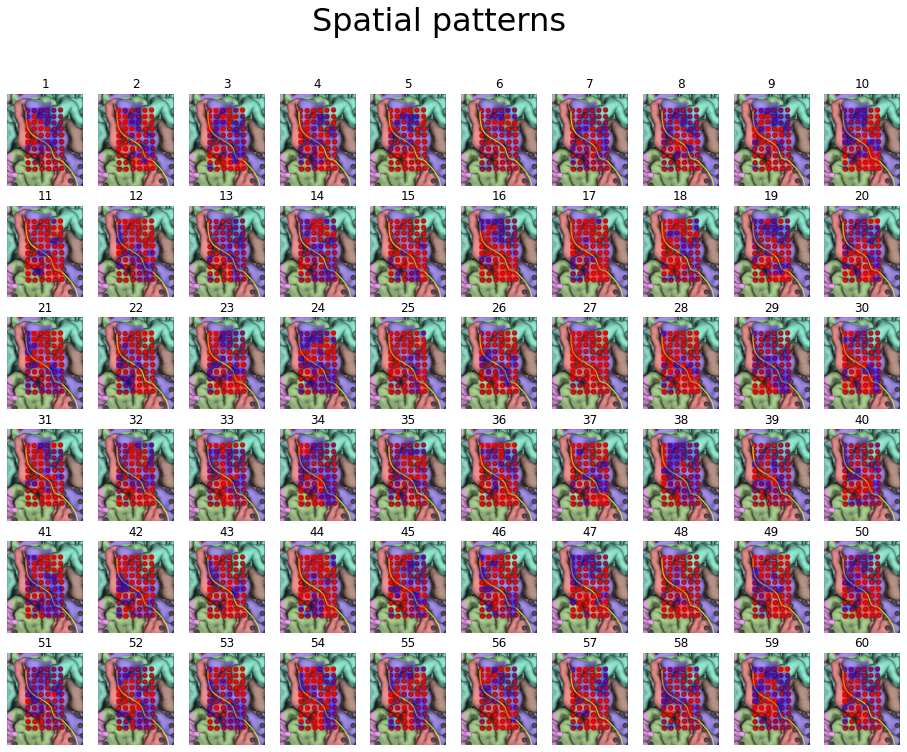

In [21]:
import matplotlib.image as mpimg
from tqdm.auto import tqdm


def plot_patterns(patterns,
                  w=10, h=6,
                  pos=np.array([1., 0., 0.]), neg=np.array([0., 0., 1.]),
                  mul=1.6*1.05, xmul=16, ymul=16,
                  xo=75, yo=57, opacity=0.5,
                  title="Spatial patterns", file_name=None,
                  overlay="brain.png",   # overlay=None,
):
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(title, fontsize=32)
    xmul, ymul = int(xmul * mul), int(ymul * mul)
    for i, f in enumerate(tqdm(patterns[:h*w])):
        ax = plt.subplot(h, w, i+1)
        ax.axis("off")
        ax.set_title(f"{i + 1}")
        pat = f.reshape((6, 10)).T.copy()
        if overlay is None:
            ax.imshow(pat)
        else:
            im = mpimg.imread(overlay)
            pat -= pat.min()
            pat /= pat.max()
            for y in range(pat.shape[0]):
                for x, e in enumerate(pat[y]):
                    patch = im[y*ymul+yo:(y)*ymul+int(ymul*1.0)+yo, x*xmul+xo:(x+1)*xmul+xo, :3]
                    k = (1 - (1 - abs(e - 0.5) * 2) ** 2) * (1 - opacity) + opacity
                    patch[:, :, :] = patch * k + (pos if e > 0.5 else neg) * (1 - k)
            ax.imshow(im)
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

plot_patterns(csp.patterns_, file_name="spatial_patterns_on_brain.png")

In [237]:
csp.
for i in range(1, 61):
    plt.subplot(10, 6, )

    csp.patterns_.shape)

(60, 60)


In [219]:
from tqdm.auto import trange


for n_filters in trange(1, 10):
    for start_freq in trange(1,)
    raw.copy().filter()

<RawArray | 60 x 507025 (422.5 s), ~232.2 MB, data loaded>

In [215]:



#%%
# %%

epochs = mne.Epochs(raw, events, tmin=-0.75, tmax=0.75, baseline=(None, 0))
print(epochs)

Not setting metadata
Not setting metadata
90 matching events found
Setting baseline interval to [-0.75, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  90 events (good & bad), -0.75 - 0.75 sec, baseline -0.75 – 0 sec, ~60 kB, data not loaded,
 '1': 30
 '2': 30
 '3': 30>


Epoch 1
Average


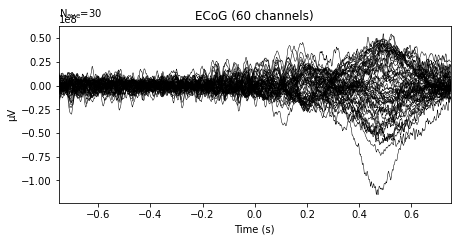

Standard Error


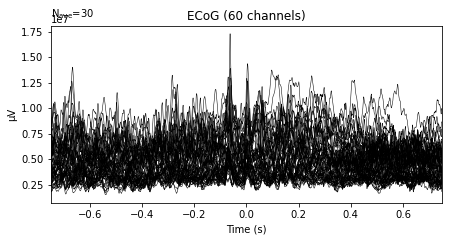

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


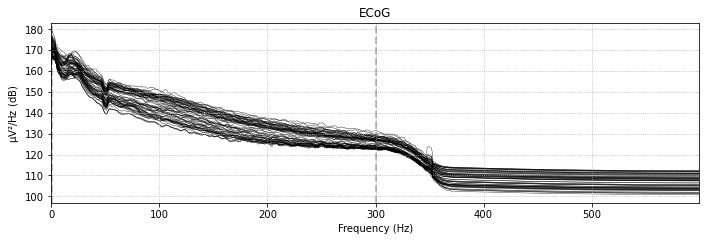

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


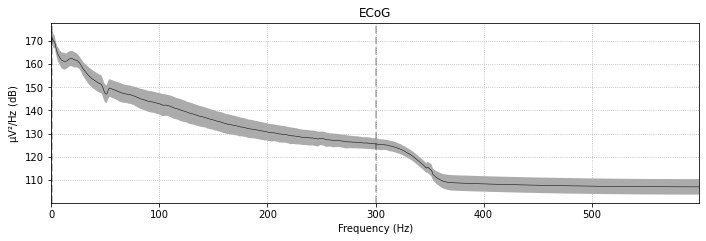

Epoch 2
Average


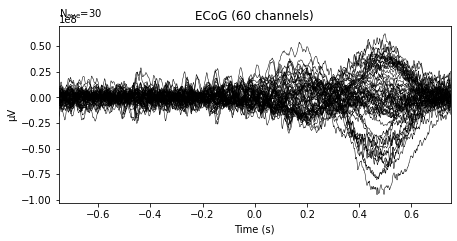

Standard Error


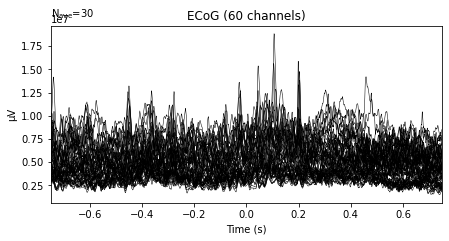

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


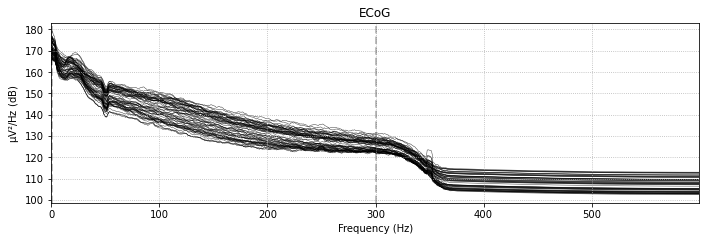

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


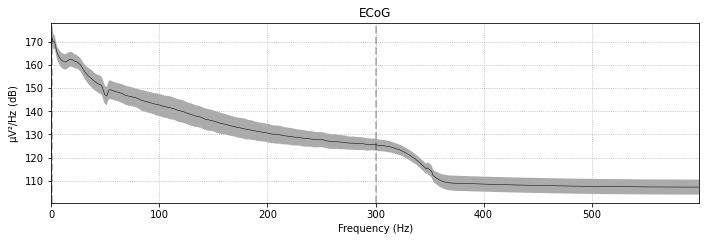

Epoch 3
Average


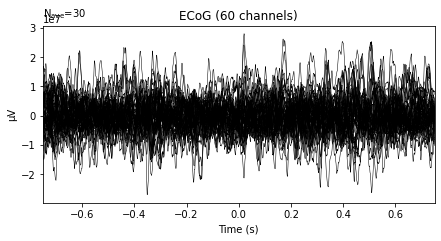

Standard Error


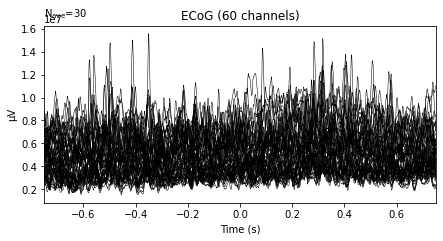

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


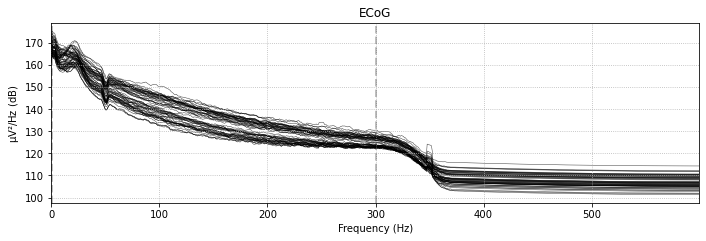

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


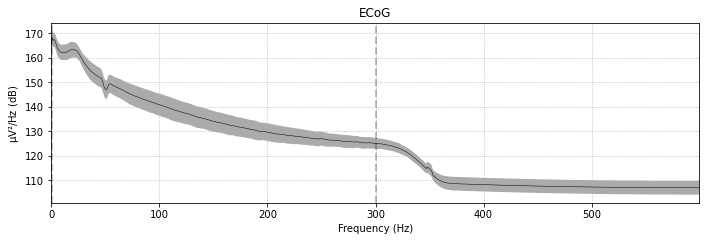

In [216]:
for i in '123':
    print("Epoch", i)
    print("Average")
    evoked = epochs[i].average()
    evoked.plot()
    print("Standard Error")
    epochs[i].standard_error().plot()
    print("PSD")
    epochs[i].plot_psd()
    epochs[i].plot_psd(average=True)

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


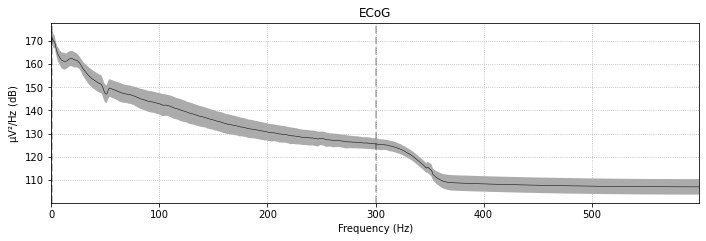

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


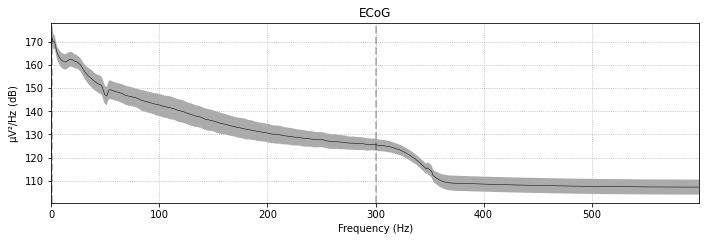

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


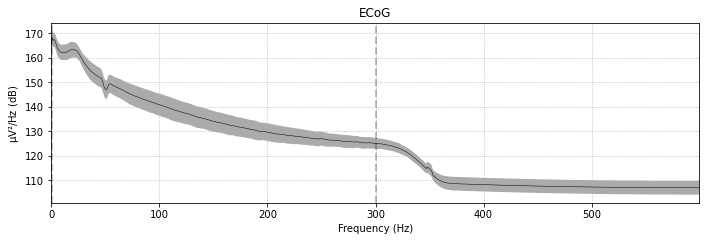

In [217]:
for i in "123":
    epochs[i].plot_psd(average=True)

In [79]:
ev = epochs["3"]
ev
ev.verbose = True

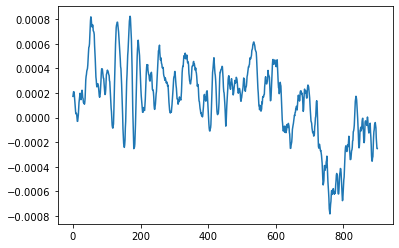

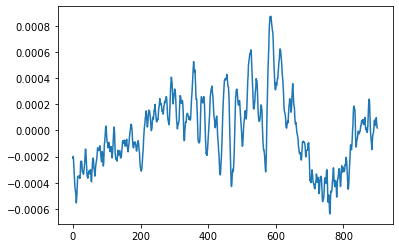

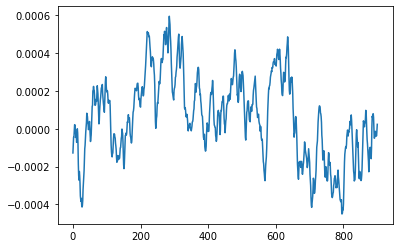

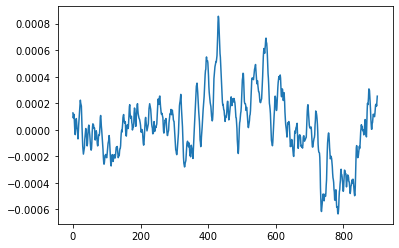

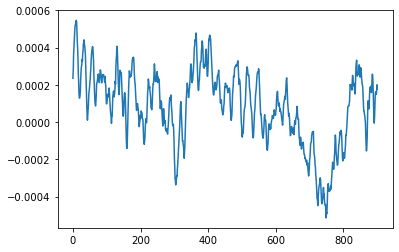

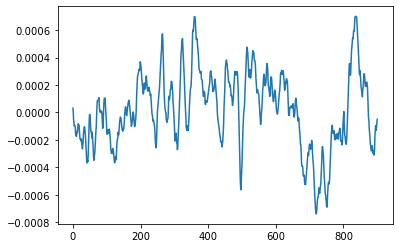

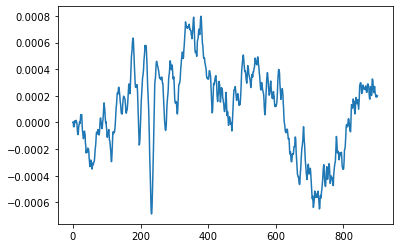

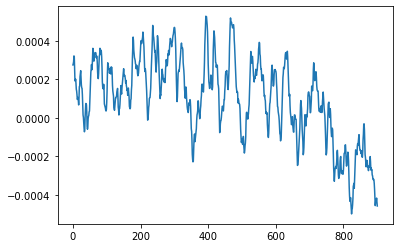

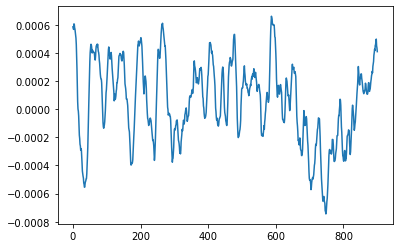

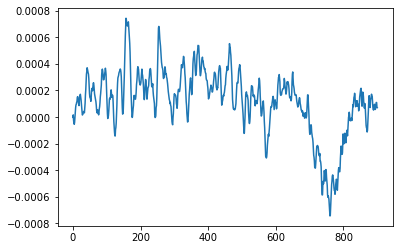

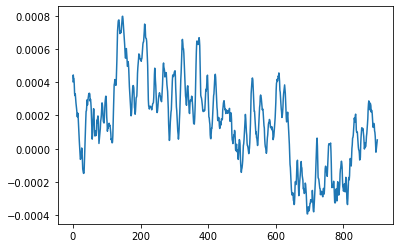

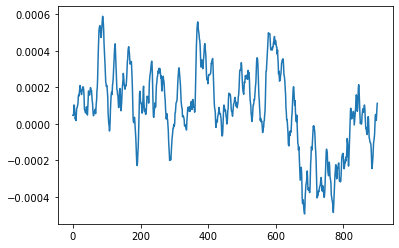

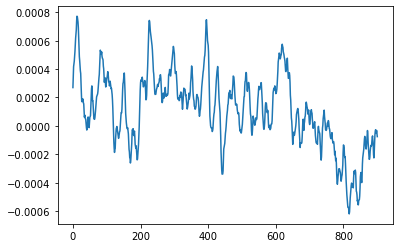

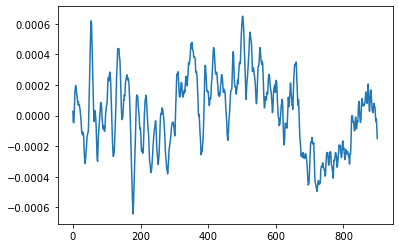

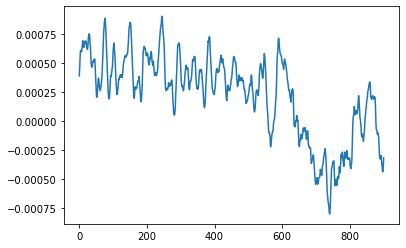

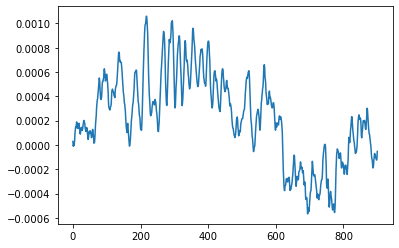

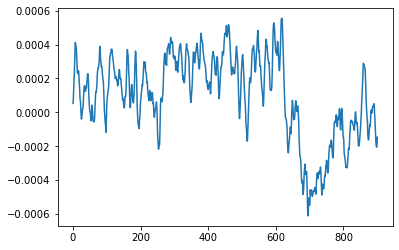

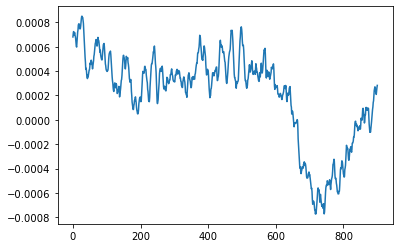

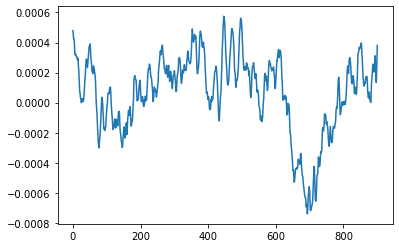

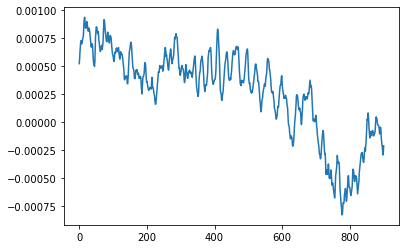

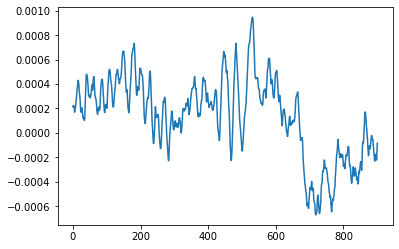

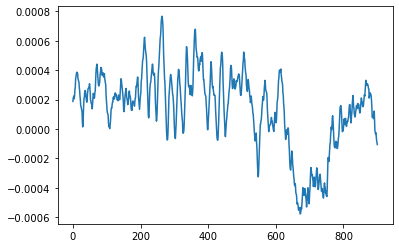

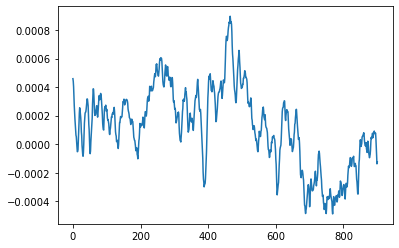

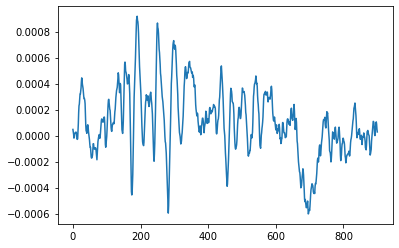

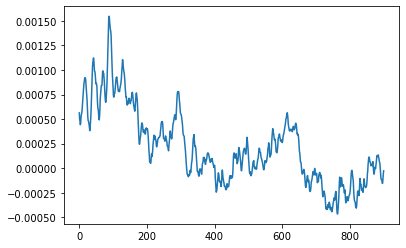

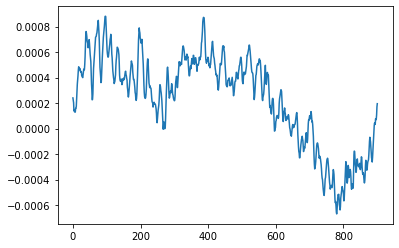

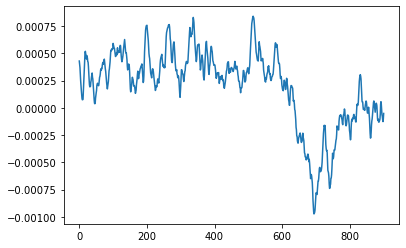

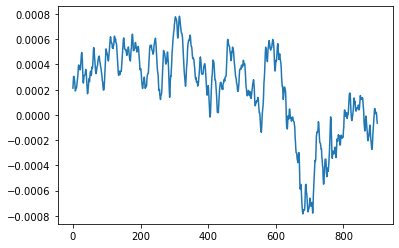

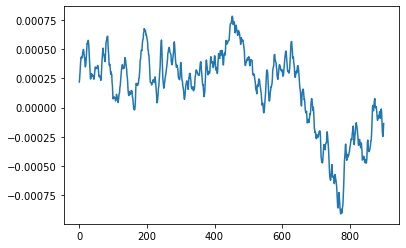

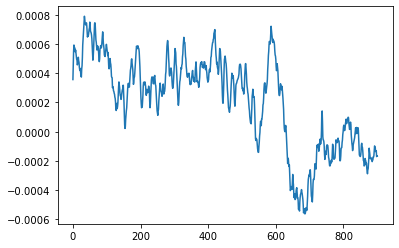

In [87]:
for event in epochs["3"]:
    plt.plot(event.mean(axis=0))
    plt.show()

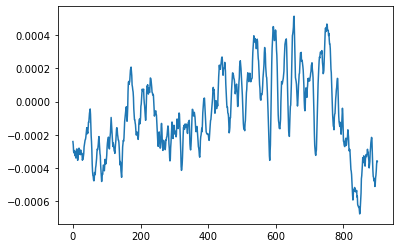

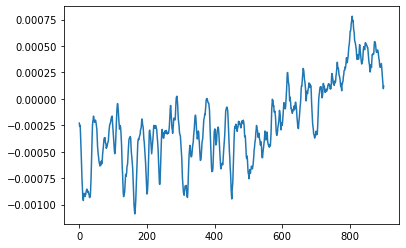

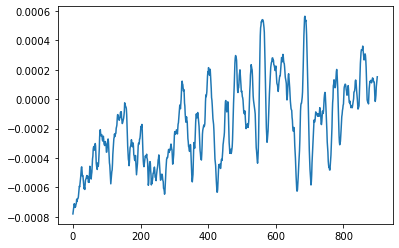

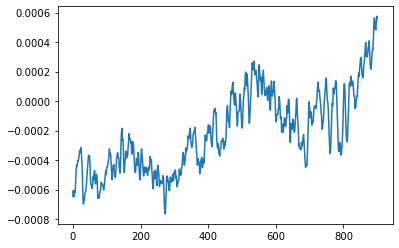

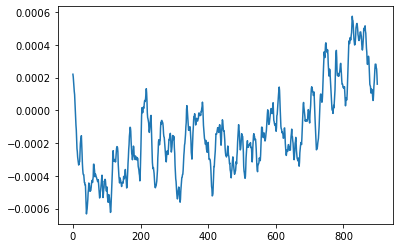

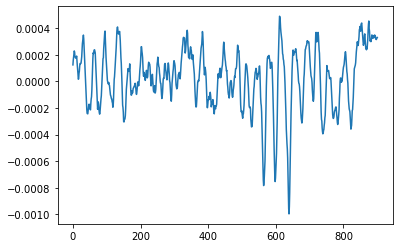

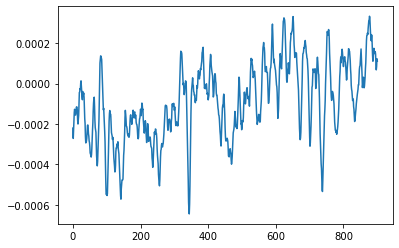

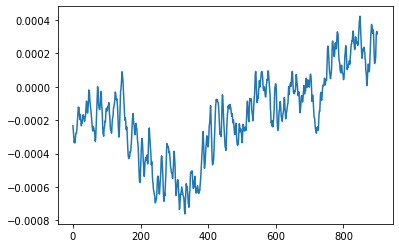

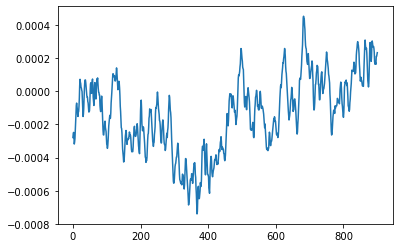

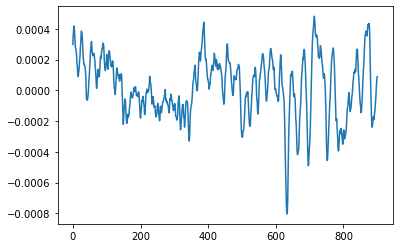

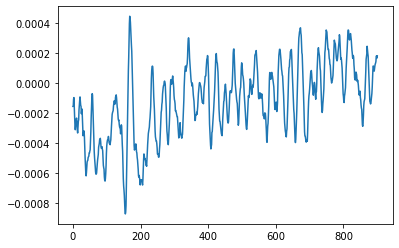

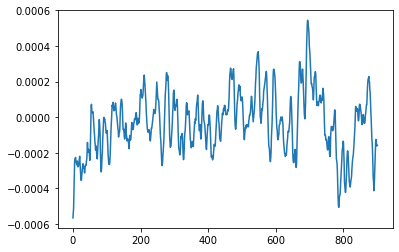

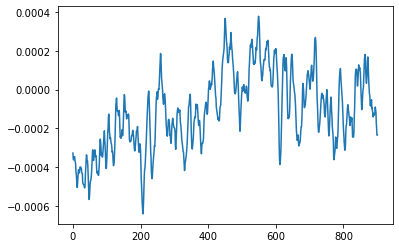

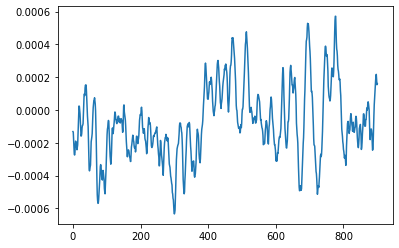

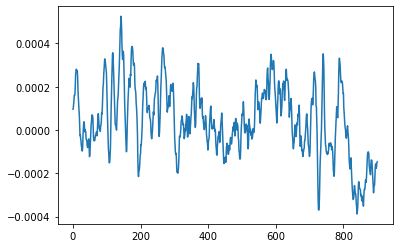

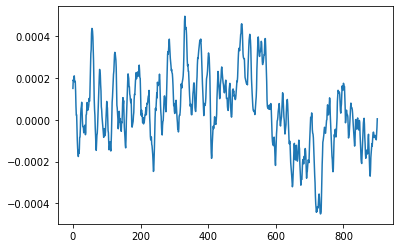

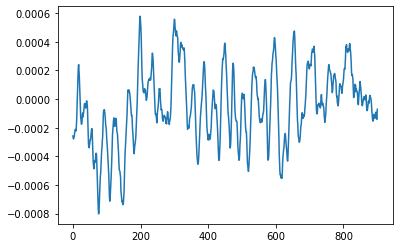

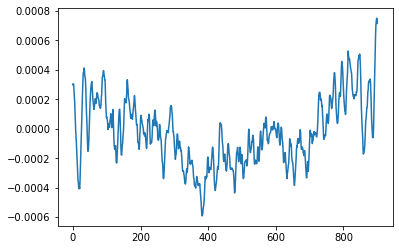

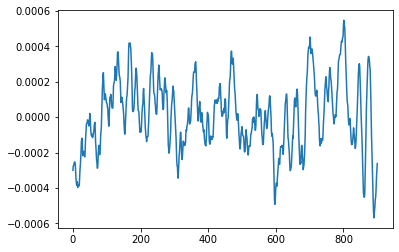

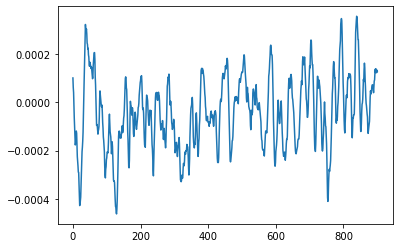

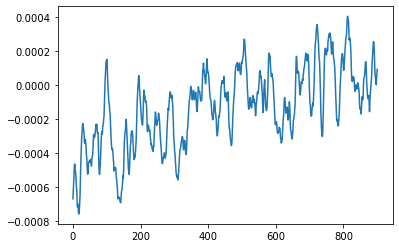

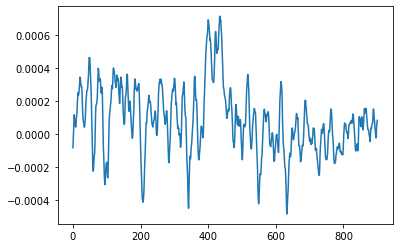

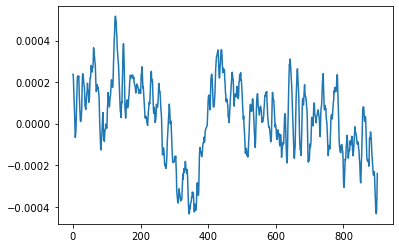

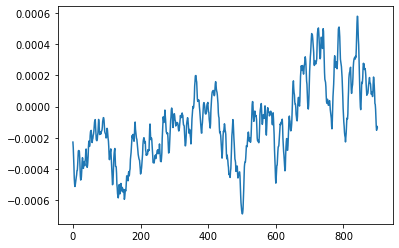

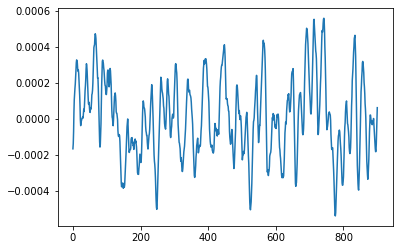

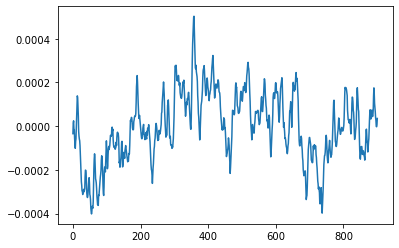

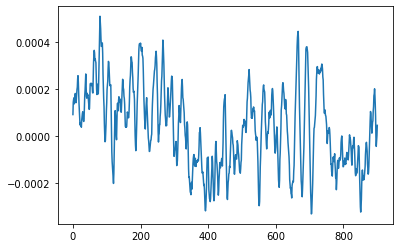

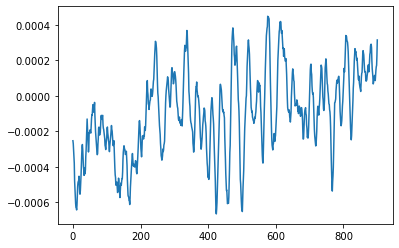

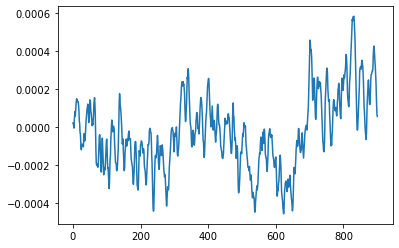

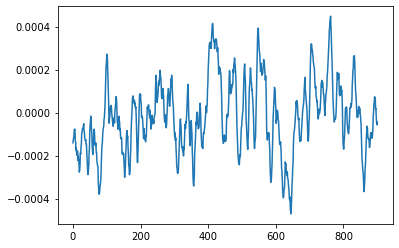

In [88]:
for event in epochs['3']:
    plt.plot(event.mean(axis=0))
    plt.show()

Loading data for 90 events and 1801 original time points ...
0 bad epochs dropped
Loading data for 90 events and 1801 original time points ...
Loading data for 20 events and 1801 original time points ...


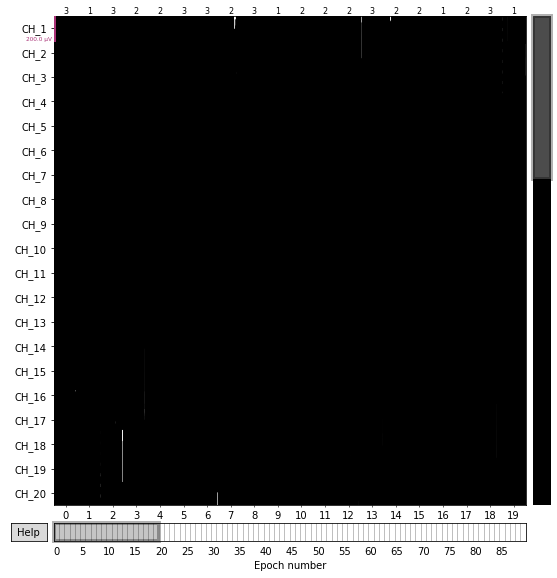

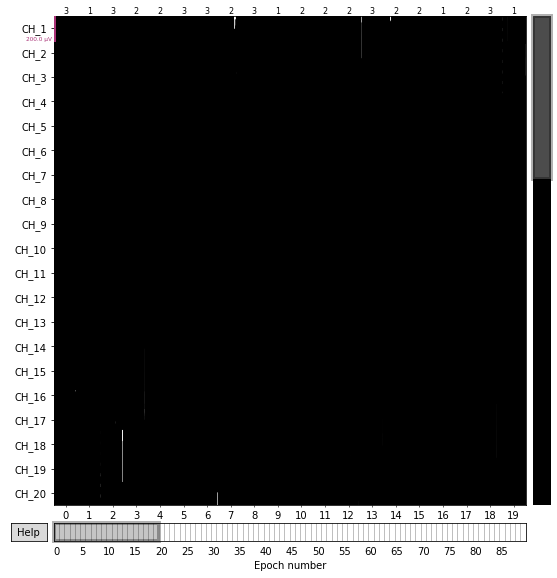

In [61]:
epochs.plot(events=events)

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat


data = loadmat("ECoG_Handpose.mat")

In [2]:
print(data)
y = data["y"]
y.shape

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 23 10:38:21 2020', '__version__': '1.0', '__globals__': [], 'y': array([[ 0.00000000e+00,  8.33333333e-04,  1.66666667e-03, ...,
         4.22518333e+02,  4.22519167e+02,  4.22520000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.06701961e+05, -1.06699477e+05, -1.06697859e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.62051094e+04, -8.62023672e+04, -8.61986562e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.53902262e-01,  1.53902262e-01,  1.53902262e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61574081e-01,  1.61574081e-01,  1.61574081e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.34732822e-01,  2.34732822e-01,  2.34732822e-01]])}


(67, 507025)

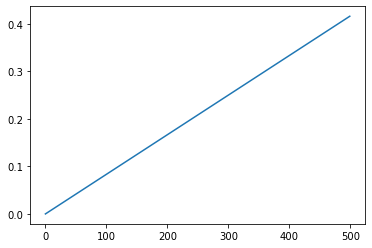

In [3]:
from matplotlib import pyplot as plt


plt.plot(y[0][:500])

In [4]:
df = pd.DataFrame(y.T, columns=["time"] + [f"CH_{i + 1}" for i in range(60)] +
             ['paradigm_info', 'data_glove_thumb', 'data_glove_index', 'data_glove_middle', 'data_glove_ring', 'data_glove_little'])
df

time           CH_1          CH_2          CH_3           CH_4  \
0         0.000000       0.000000      0.000000      0.000000       0.000000   
1         0.000833       0.000000      0.000000      0.000000       0.000000   
2         0.001667       0.000000      0.000000      0.000000       0.000000   
3         0.002500       0.000000      0.000000      0.000000       0.000000   
4         0.003333       0.000000      0.000000      0.000000       0.000000   
...            ...            ...           ...           ...            ...   
507020  422.516667 -106697.578125 -86204.289062 -76535.585938 -103944.351562   
507021  422.517500 -106698.921875 -86203.906250 -76537.109375 -103945.375000   
507022  422.518333 -106701.960938 -86205.109375 -76535.445312 -103945.046875   
507023  422.519167 -106699.476562 -86202.367188 -76532.234375 -103945.843750   
507024  422.520000 -106697.859375 -86198.656250 -76531.257812 -103942.421875   

                CH_5          CH_6          CH_7          CH_8          CH_9  \
0           0.000000      0.000000      0.000000      0.000000      0.000000   
1           0.000000      0.000000      0.000000      0.000000      0.000000   
2           0.000000      0.000000      0.000000      0.000000      0.000000   
3           0.000000      0.000000      0.000000      0.000000      0.000000   
4           0.000000      0.000000      0.000000      0.000000      0.000000   
...              ...           ...           ...           ...           ...   
507020 -59508.328125 -39716.640625 -12350.508789  46311.046875  13856.023438   
507021 -59508.292969 -39717.875000 -12354.244141  46318.351562  13859.705078   
507022 -59511.664062 -39718.042969 -12355.633789  46322.660156  13859.116211   
507023 -59508.625000 -39713.183594 -12354.968750  46326.210938  13862.730469   
507024 -59510.562500 -39712.156250 -12353.298828  46323.835938  13860.594727   

        ...         CH_57         CH_58        CH_59         CH_60  \
0       ...      0.000000      0.000000     0.000000      0.000000   
1       ...      0.000000      0.000000     0.000000      0.000000   
2       ...      0.000000      0.000000     0.000000      0.000000   
3       ...      0.000000      0.000000     0.000000      0.000000   
4       ...      0.000000      0.000000     0.000000      0.000000   
...     ...           ...           ...          ...           ...   
507020  ... -65758.367188 -33892.039062 -4235.358887  51480.582031   
507021  ... -65760.468750 -33896.398438 -4240.333984  51477.101562   
507022  ... -65757.734375 -33894.804688 -4240.388672  51475.777344   
507023  ... -65757.828125 -33896.714844 -4241.463867  51473.503906   
507024  ... -65753.156250 -33894.445312 -4238.678711  51475.753906   

        paradigm_info  data_glove_thumb  data_glove_index  data_glove_middle  \
0                 0.0           0.00000          0.000000           0.000000   
1                 0.0           0.00000          0.000000           0.000000   
2                 0.0           0.00000          0.000000           0.000000   
3                 0.0           0.00000          0.000000           0.000000   
4                 0.0           0.00000          0.000000           0.000000   
...               ...               ...               ...                ...   
507020            0.0           0.70303          0.178975           0.153902   
507021            0.0           0.70303          0.178975           0.153902   
507022            0.0           0.70303          0.178975           0.153902   
507023            0.0           0.70303          0.178975           0.153902   
507024            0.0           0.70303          0.178975           0.153902   

        data_glove_ring  data_glove_little  
0              0.000000           0.000000  
1              0.000000           0.000000  
2              0.000000           0.000000  
3              0.000000           0.000000  
4              0.000000           0.000000  
...                 

<AxesSubplot:>

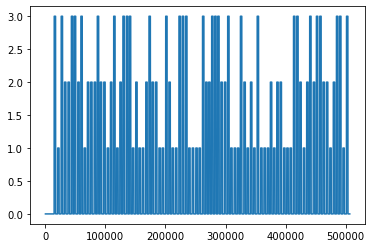

In [14]:
df.paradigm_info.plot()

index              0
paradigm_info    120
dtype: int64


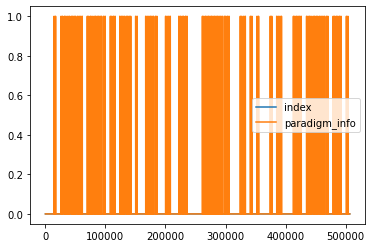

In [23]:
changes = ((df.paradigm_info.iloc[1:].reset_index() - df.paradigm_info.iloc[:-1].reset_index()).abs() > 1).astype("int")
changes.plot()
print(changes.sum())

In [6]:
print(df.data_glove_index.describe())
print(df.paradigm_info.value_counts())

count    507025.000000
mean          0.247886
std           0.301131
min           0.000000
25%           0.075524
50%           0.134398
75%           0.221395
max           1.000000
Name: data_glove_index, dtype: float64
0.0    286801
1.0     73440
2.0     73440
3.0     73344
Name: paradigm_info, dtype: int64


<AxesSubplot:>

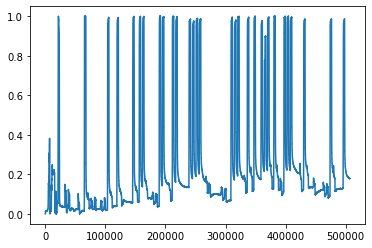

In [7]:
df.data_glove_index.reset_index(drop=True).plot()

<AxesSubplot:>

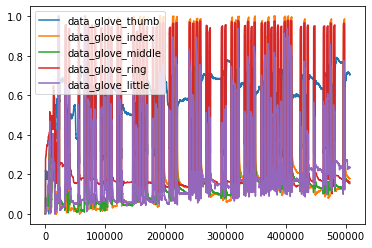

In [8]:
glove_columns = [x for x in df.columns if "glove" in x]
df[glove_columns].plot()

In [26]:
len(df)

507025

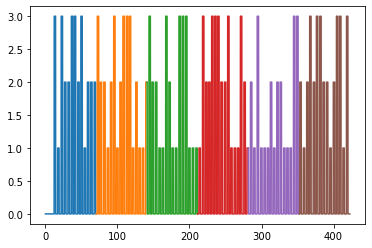

In [24]:
from tqdm.auto import tqdm


n_folds = 8
folds = []
fold_size = len(df) // n_folds
for i in range(0, len(df), fold_size):
    folds.append(df.iloc[i:i+fold_size])
    # folds.append(df.iloc[i//fold_size:].iloc[::fold_size])
for fold in folds:
    plt.plot(fold.time, fold.paradigm_info)

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x
    

def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def cross_fold(models, folds, metrics=percentage_accuracy_score):
    models = wrap_list(models)
    metrics = wrap_list(metrics)
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        for i, (x_test, y_test) in enumerate(bar := tqdm(folds)):
            x_train, y_train = map(pd.concat, zip(*(folds[:i] + folds[i+1:])))
            model.fit(x_train, y_train)
            y__test = model.predict(x_test)
            predicted.append(y__test)
            true.append(y_test)
            test_acc = percentage_accuracy_score(y_test, y__test)
            test_accs.append(test_acc)
            bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
        true, predicted = pd.concat(true), np.concatenate(predicted)
        for metric in tqdm(metrics):
            # accuracy decomposes cleanly, but other metrics might not
            print(f"{metric.__name__}: {metric(true, predicted):.4f}")
            
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()

# Check glove baseline

  0%|          | 0/4 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 56.5655


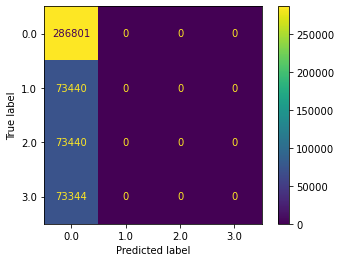





KNeighborsClassifier(n_neighbors=3)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


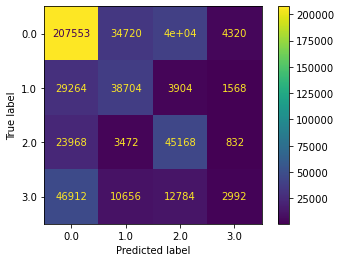





KNeighborsClassifier(n_neighbors=11)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


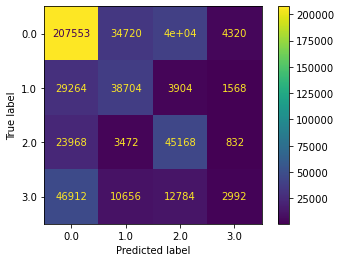





SGDClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 71.0152


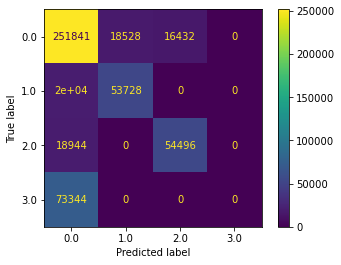

In [25]:
import sklearn
import sklearn.dummy  # not sure why it's not there by default
import sklearn.neighbors


model_templates = [
          sklearn.dummy.DummyClassifier(),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=11),
          sklearn.linear_model.SGDClassifier(),
          # sklearn.svm.SVC(kernel="rbf"),
          # sklearn.svm.SVC(kernel="poly"),
          # sklearn.svm.SVC(kernel="gaussian")
]
cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

In [ ]:

cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

# TODO
* Calculate trial info
* Try random Cross-Validation
* Import into MNE
* Use Catboost
* Use real features
* Windowed features
* Band-power
* Filtering
* TDA

In [12]:
1/0

ZeroDivisionError: division by zero